# Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('german_credit_data.csv', index_col=0)
df.shape

(1000, 9)

In [3]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [4]:
df.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,40,male,3,own,little,little,3857,30,car
997,38,male,2,own,little,NaN,804,12,radio/TV
998,23,male,2,free,little,little,1845,45,radio/TV
999,27,male,2,own,moderate,moderate,4576,45,car


In [5]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [6]:
num_cols = ['Age', 'Credit amount', 'Duration']

In [7]:
cat_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in cat_cols:
    values = [str(val) for val in pd.unique(df[col])]
    print(f'Unique values of feature "{col}": ', ', '.join(values))
    print()

Unique values of feature "Sex":  male, female

Unique values of feature "Job":  2, 1, 3, 0

Unique values of feature "Housing":  own, free, rent

Unique values of feature "Saving accounts":  nan, little, quite rich, rich, moderate

Unique values of feature "Checking account":  little, moderate, nan, rich

Unique values of feature "Purpose":  radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others



Из описания датасета выяснил, что пропуски в признаках `Saving accounts` и `Checking account` означают, что у клиента нет таких счетов. Поэтому создадим новую категорию `doesn't have` вместо пропусков.  

In [8]:
df = df.fillna("doesn't have")
df.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

Вернем текстовые категории для признака `Job` из описания датасета для удобства в EDA.  

In [9]:
df['Job'].replace(0, 'unskilled non-resident', inplace=True)
df['Job'].replace(1, 'unskilled resident', inplace=True)
df['Job'].replace(2, 'skilled', inplace=True)
df['Job'].replace(3, 'highly skilled', inplace=True)

In [10]:
values = [str(val) for val in pd.unique(df['Job'])]
print('Unique values of feature "Job": ', ', '.join(values))

Unique values of feature "Job":  skilled, unskilled resident, highly skilled, unskilled non-resident


### EDA

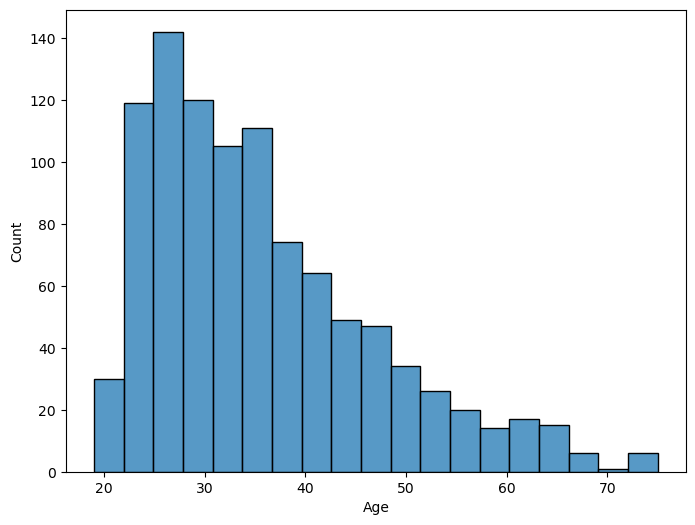

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(x=df['Age'])
plt.show()

Самый "кредитоактивный" возраст между 23 и 37.   

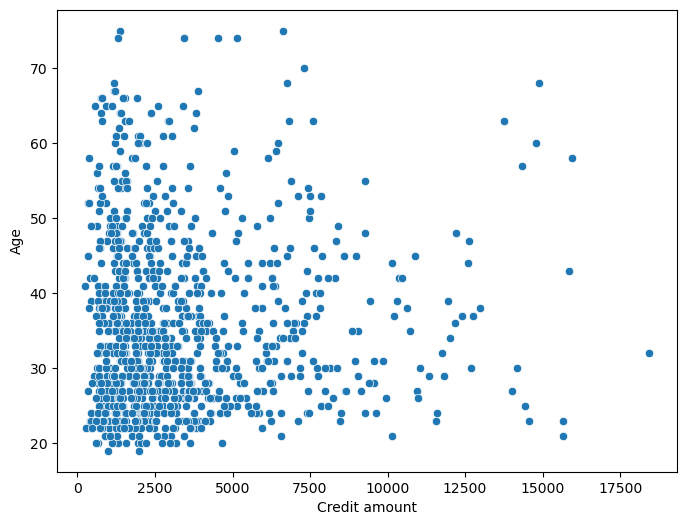

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Credit amount', y='Age')
plt.show()

С возрастом клиентов уменьшается заемная сумма.  

In [13]:
np.corrcoef(df['Credit amount'].values, df['Duration'].values)[0, 1]

0.6249841983009831

Сильная корреляция между суммой кредита и сроком погашения - значит, чем больше берут денег, тем дольше планируют их возвращать. Это логично :)   

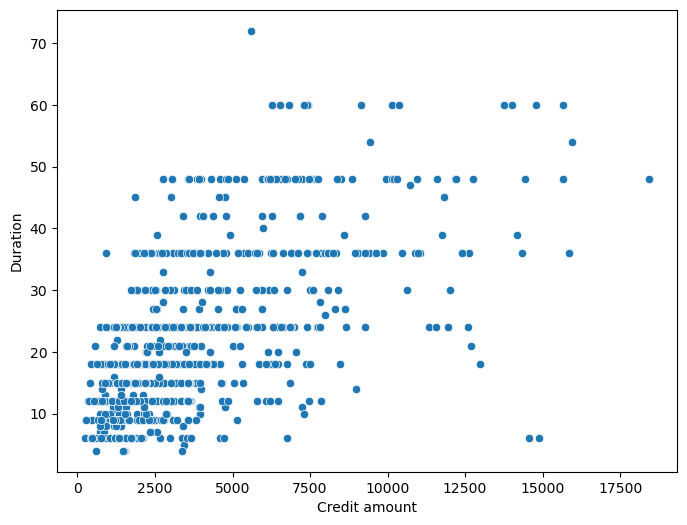

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Credit amount', y='Duration')
plt.show()

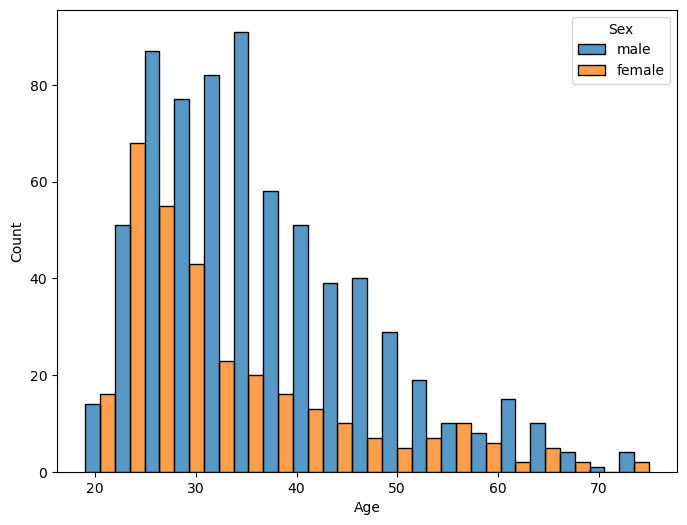

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Age', hue='Sex', multiple='dodge')
plt.show()

До 25 лет женщины берут больше кредитов, чем мужчины. А потом, видимо, у них появляются мужья и эта обязанность переходит на них :)  

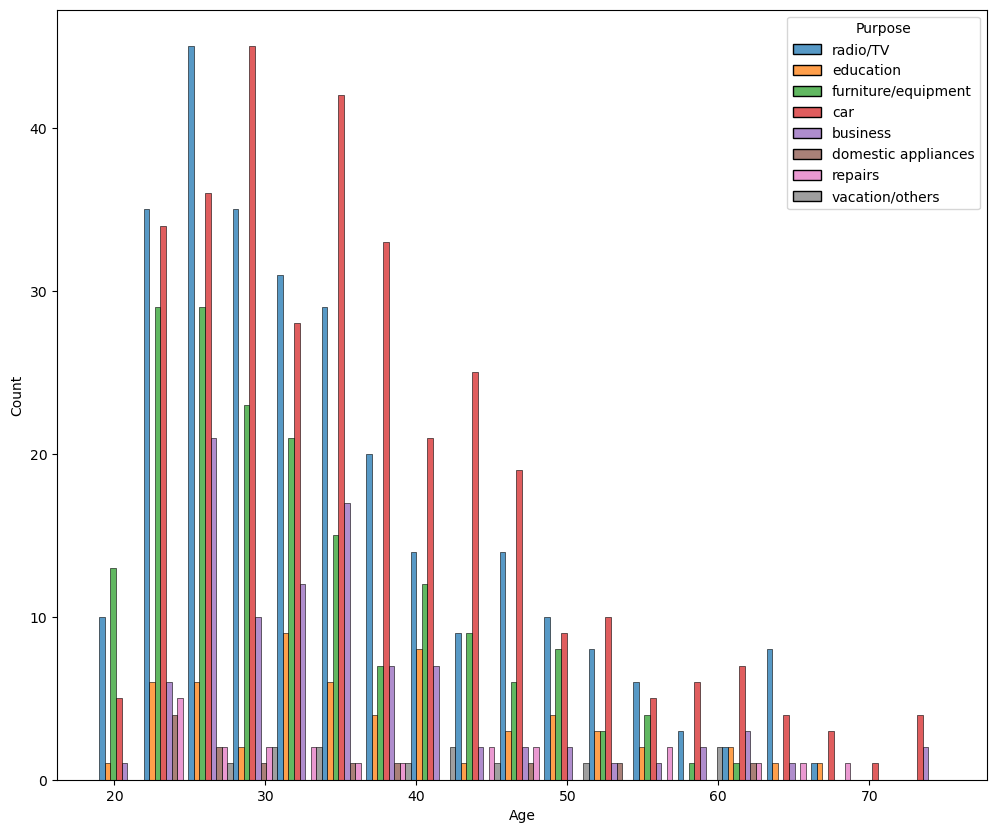

In [16]:
plt.figure(figsize=(12, 10))
sns.histplot(data=df, x='Age', hue='Purpose', multiple='dodge')
plt.show()

В топ-3 цели кредитов входят: авто, техника, мебель.  

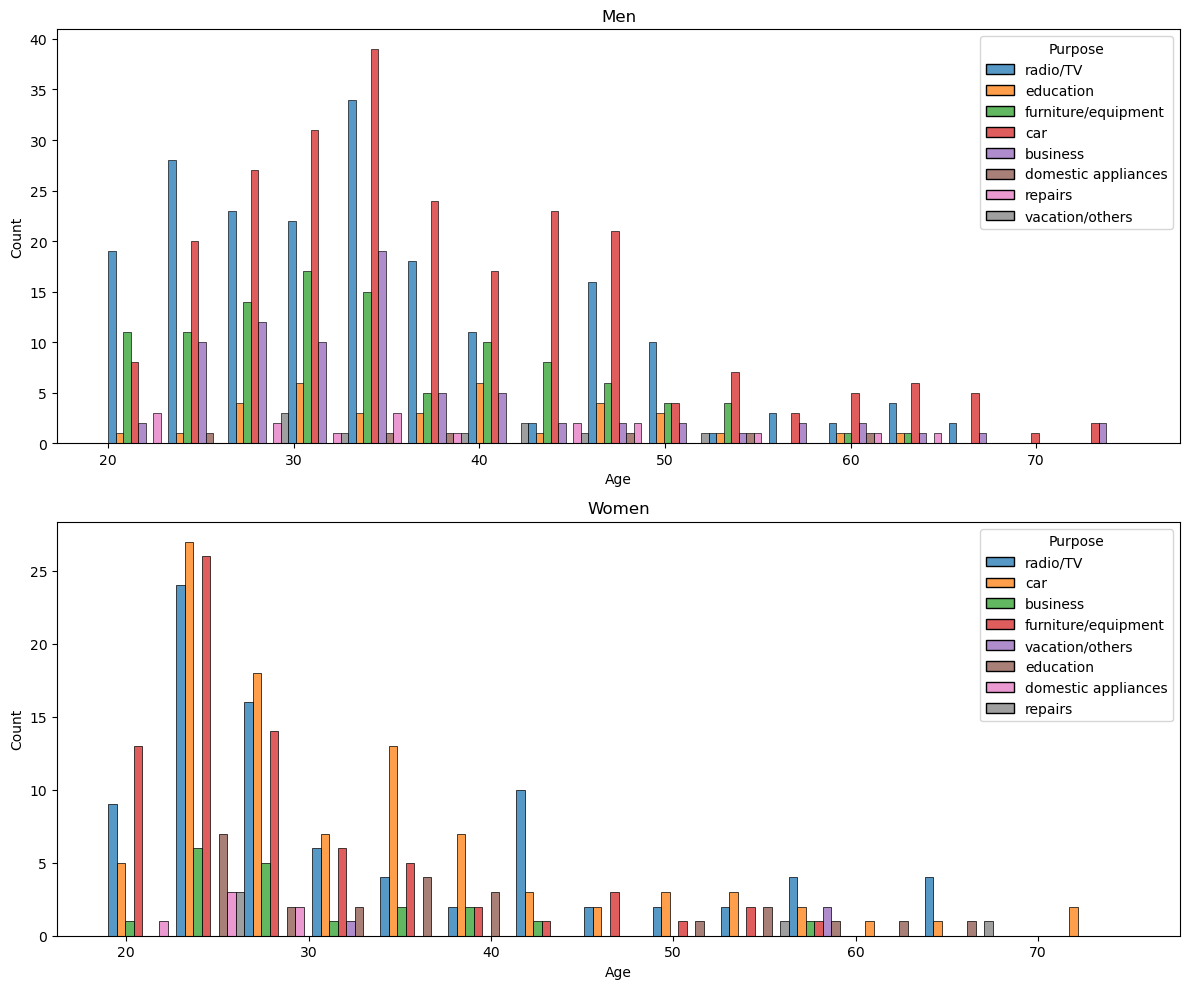

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
ax = axes[0]
sns.histplot(data=df.loc[df['Sex'] == 'male'], x='Age', hue='Purpose', multiple='dodge', ax=ax)
ax.set_title('Men')
ax = axes[1]
sns.histplot(data=df.loc[df['Sex'] == 'female'], x='Age', hue='Purpose', multiple='dodge', ax=ax)
ax.set_title('Women')
plt.tight_layout()

График выше показывает, на что клиенты оформляют кредит в зависимости от возраста и в разрезе пола клиента. Можно увидеть, что в основном цели кредитов обоих полов совпадают, разница лишь в том, что мужчины чаще берут кредиты на бизнес.  

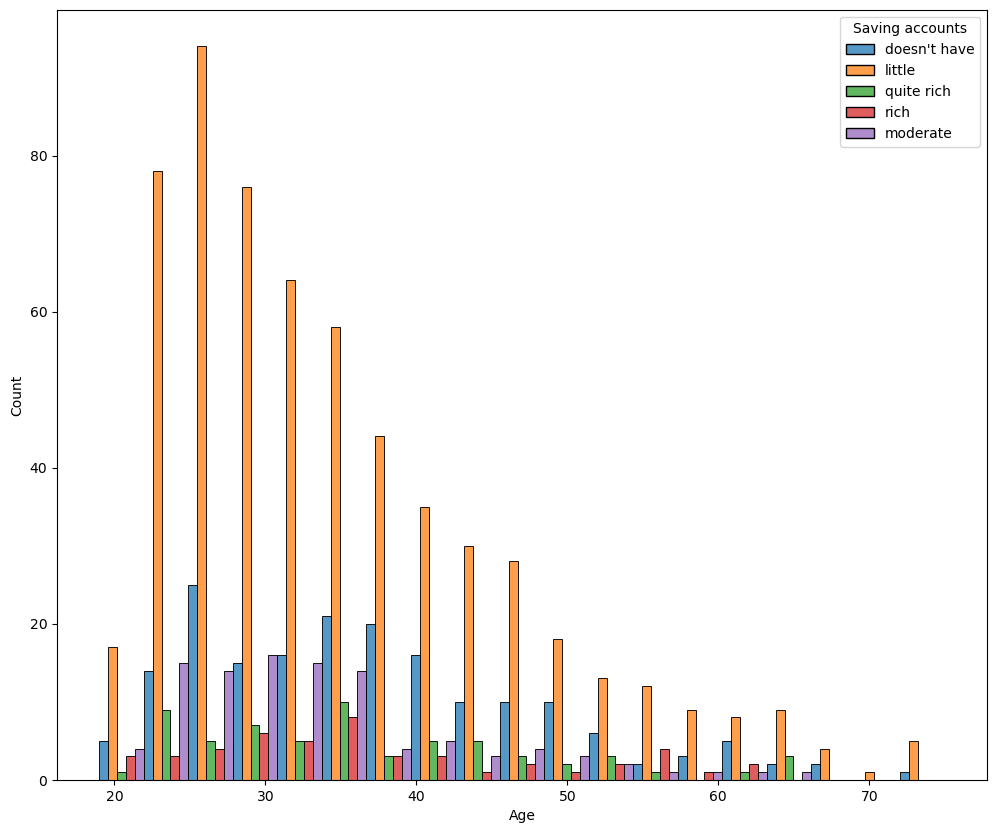

In [18]:
plt.figure(figsize=(12, 10))
sns.histplot(data=df, x='Age', hue='Saving accounts', multiple='dodge')
plt.show()

Тут видно, чтобольшинство людей имеют какие-то сбережения, но они маленькие.  

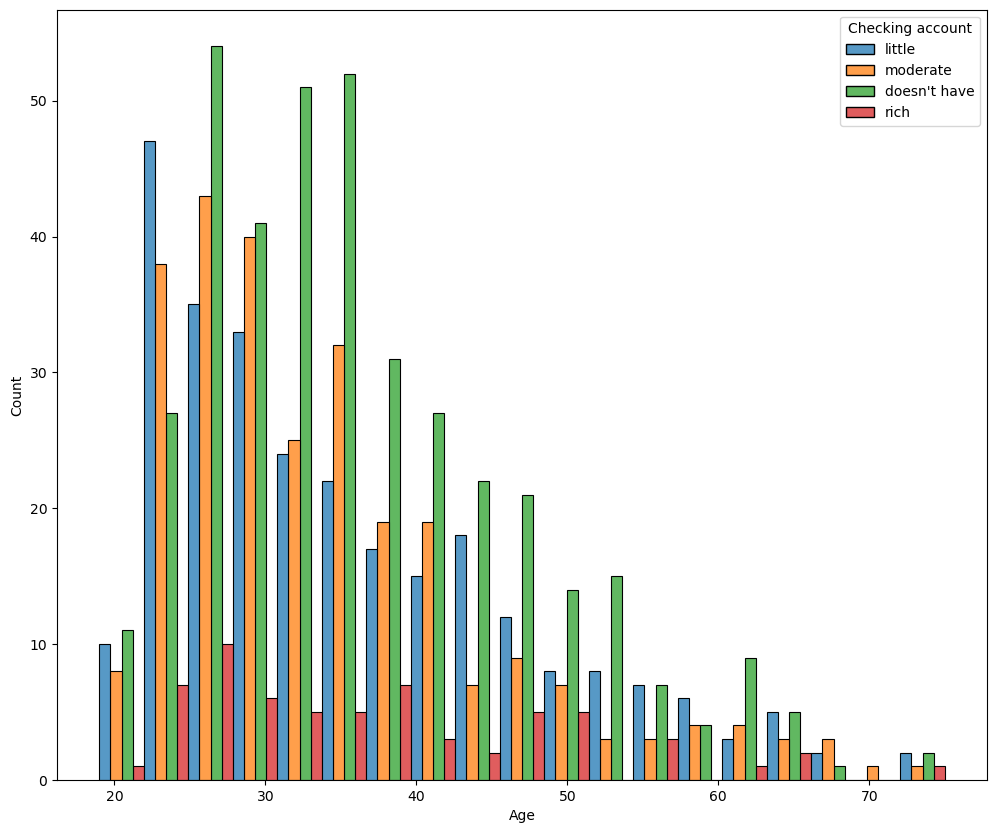

In [19]:
plt.figure(figsize=(12, 10))
sns.histplot(data=df, x='Age', hue='Checking account', multiple='dodge')
plt.show()

На этом графике видно, как много клиентов с кредитами также открывали расчетные счета в этом банке, и сколько там хранится денег.  

### Preprocessing

Закодируем категории с помощью OHE, т.к. такой способ лучше отражает расстояние.  

In [20]:
ohe_df = pd.get_dummies(df[cat_cols])

Выбрал MinMax-масштабирование, т.к. тоже считаю, что такой способ лучше подойдет метрическим моделям и, вдобавок, проще интерпретировать значения.  

In [21]:
scaler = MinMaxScaler()

minmax_df = pd.DataFrame(data=scaler.fit_transform(df[num_cols]), columns=num_cols)
minmax_df.shape

(1000, 3)

Поскольку нужно выделить кластеры в имеющихся данных и все, не буду делить их на тренировочную и тестовую выборки.  

In [22]:
df_processed = pd.concat((minmax_df, ohe_df), axis=1)
df_processed

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_highly skilled,Job_skilled,Job_unskilled non-resident,Job_unskilled resident,Housing_free,...,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,0.857143,0.050567,0.029412,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.053571,0.313690,0.647059,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0.535714,0.101574,0.117647,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0.464286,0.419941,0.558824,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.607143,0.254209,0.294118,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.214286,0.081765,0.117647,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
996,0.375000,0.198470,0.382353,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
997,0.339286,0.030483,0.117647,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
998,0.071429,0.087763,0.602941,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Попробуем отобразить данные в двухмерном пространстве, чтобы иметь представление, как в нем располагаются наблюдения.  

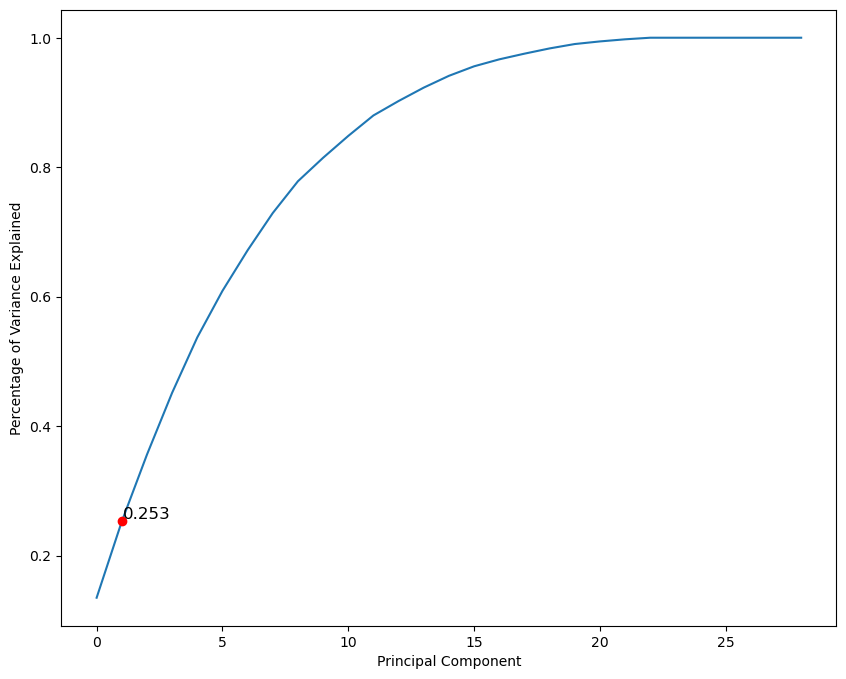

In [23]:
pca = PCA()
pca.fit(df_processed)
variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))
cumulative_variance_ratio = np.cumsum(variance_ratio)
sns.lineplot(data=cumulative_variance_ratio, zorder=1)
plt.scatter(1, round(cumulative_variance_ratio[1], 3), color='red', zorder=2)
plt.text(2, round(cumulative_variance_ratio[1], 3), round(cumulative_variance_ratio[1], 3),\
         fontsize=12, ha='center', va='bottom')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.show()

In [24]:
round(cumulative_variance_ratio[1], 3)

0.253

2 компоненты сохраняют примерно 25% дисперсии.  

In [25]:
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_processed)
df_pca.shape

(1000, 2)

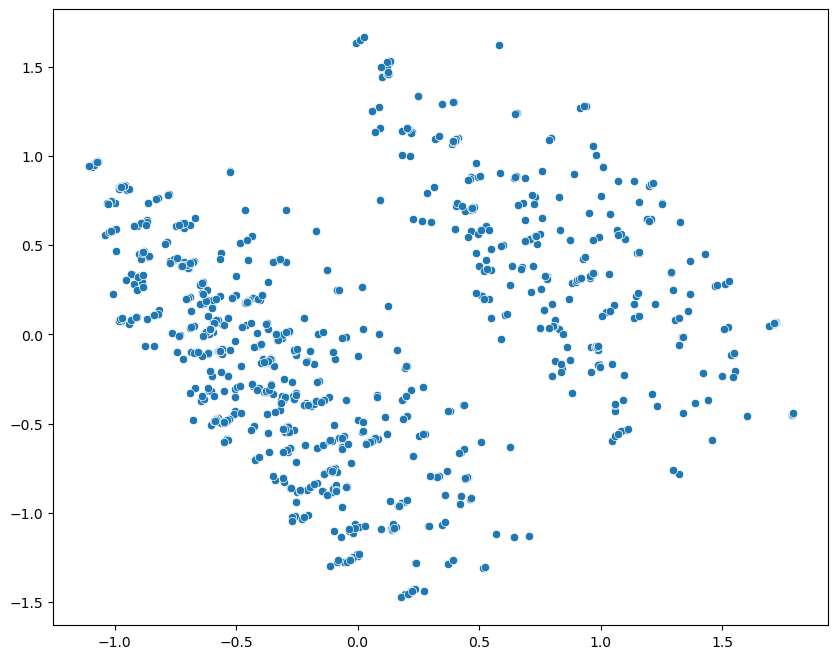

In [26]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1])
plt.show()

Четко выделяются 2 кластера, которые имеют похожую форму. Может это кластеры мужчин и женщин?  

In [27]:
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_processed)
df_tsne.shape

(1000, 2)

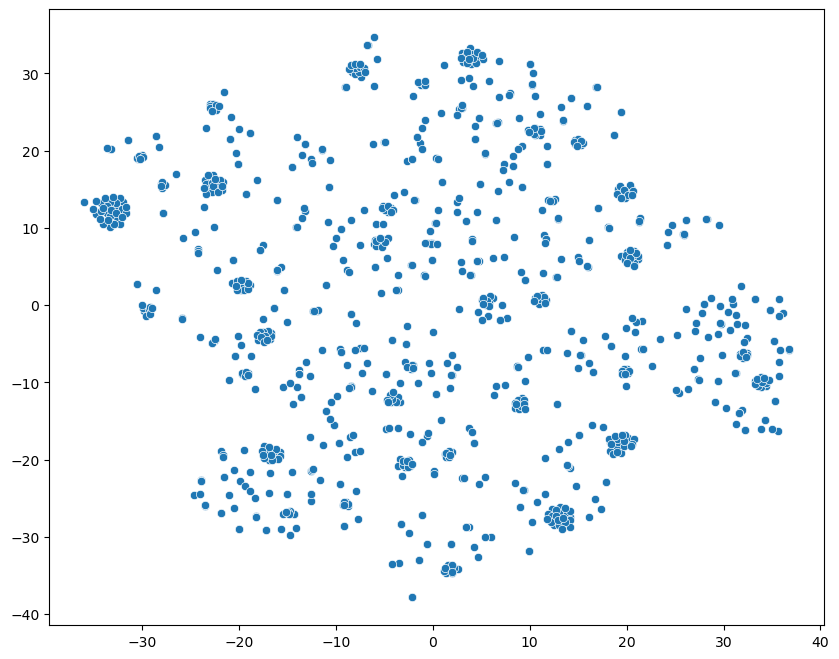

In [28]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1])
plt.show()

А тут выделилось много мелких кластеров c шумом, который не имеет четкой принадлежности к какой-либо группе.  

In [29]:
embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean').fit_transform(df_processed)
embedding.shape

(1000, 2)

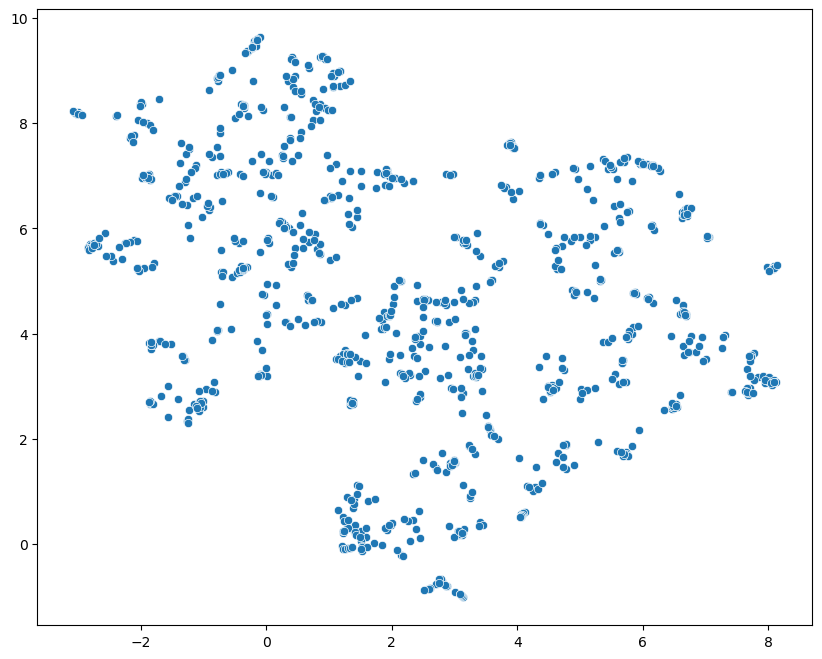

In [30]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])
plt.show()

Тут все становится еще менее понятным, хотя если приглядеться, то можно выделить 3 кластера (но кто-то другой может увидеть здесь другое количество).  
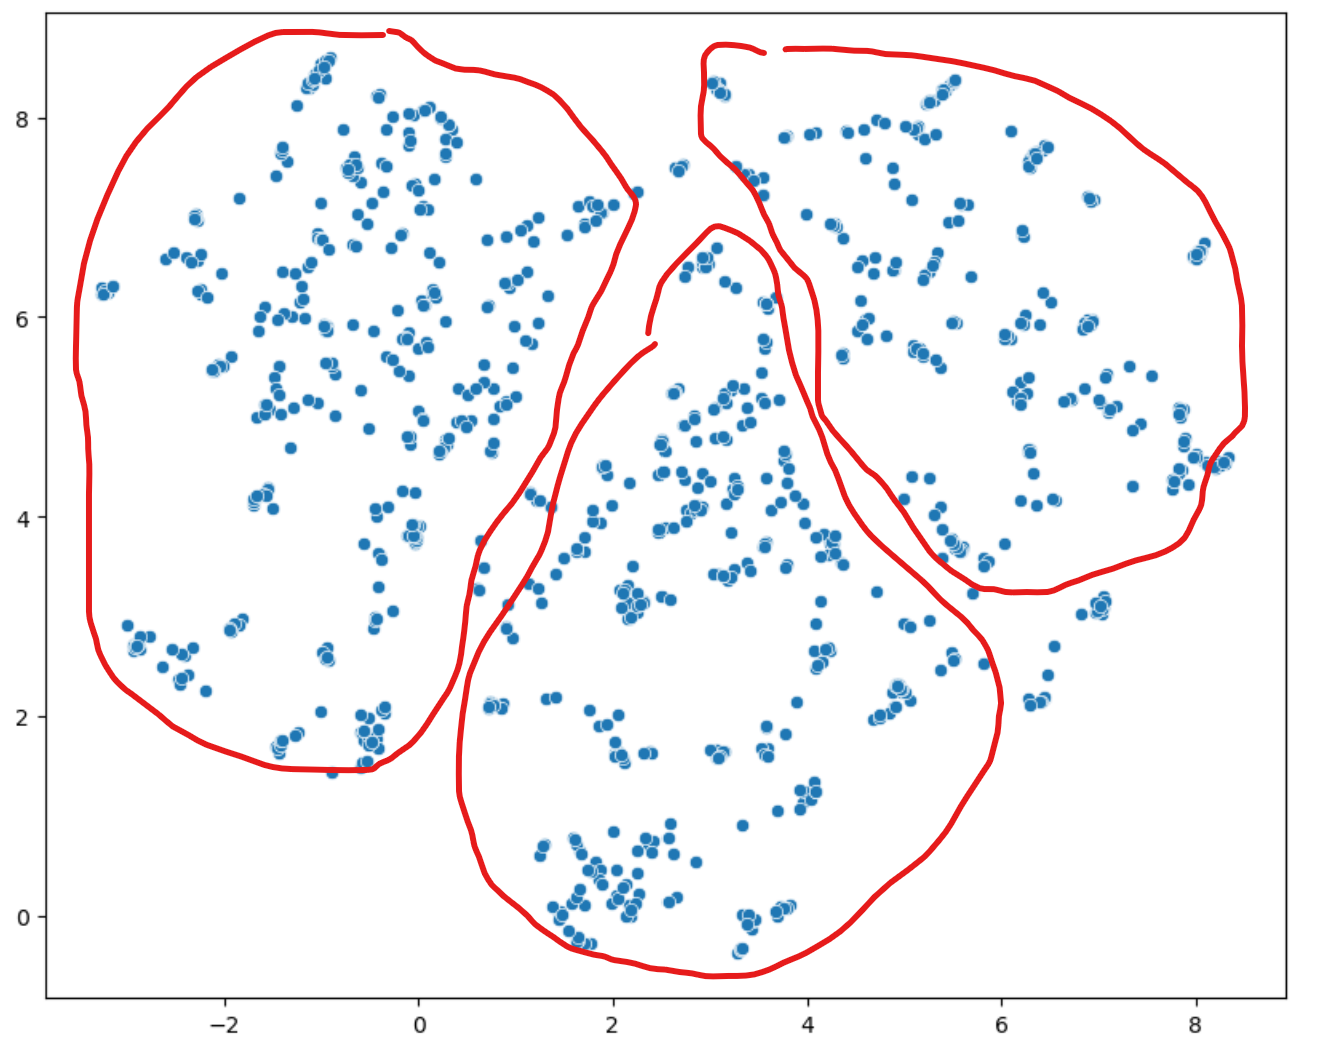

In [31]:
def elbow_plot(data, rg_s=1, rg_e=11):
    inertia = []
    for i in range(rg_s, rg_e):
        model = KMeans(n_clusters=i, random_state=42).fit(data)
        inertia_i = model.inertia_
        inertia.append(inertia_i)
        
    plt.plot(range(rg_s, rg_e), inertia, marker='o')

In [32]:
def silhouette_score_plot(data, model_name, rg_s=2, rg_e=11):
    silhouette = []
    for i in range(rg_s, rg_e):
        if model_name == 'kmeans':
            model = KMeans(n_clusters=i, random_state=42).fit(data)
        elif model_name == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=i).fit(data)
        labels = model.labels_
        score = silhouette_score(data, labels)
        silhouette.append(score)
        
    plt.plot(range(rg_s, rg_e), silhouette, marker='o')

### Modelling

#### KMeans

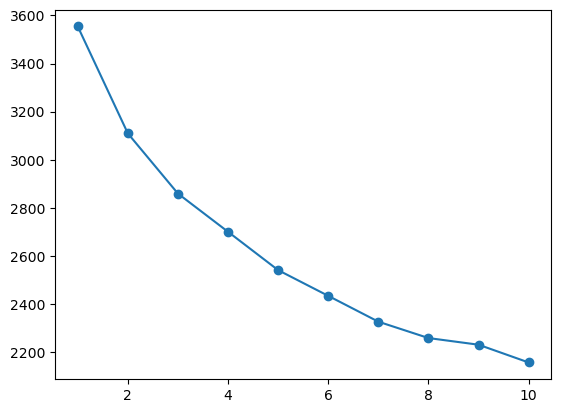

In [33]:
elbow_plot(df_processed)

По графику локтя оптимально количество кластеров определить проблематично.  

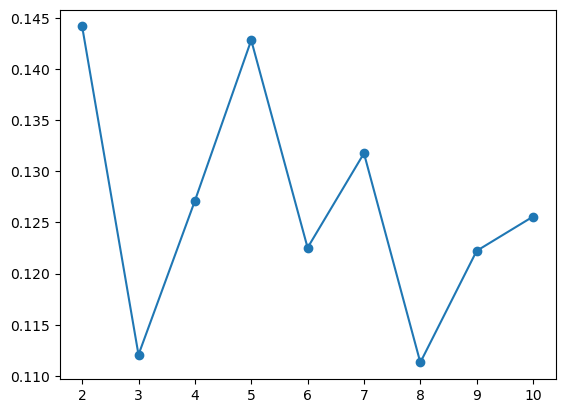

In [34]:
silhouette_score_plot(df_processed, 'kmeans')

По значениям силуэта можно сказать, что тут либо 2, либо 5 кластеров. Попробуем оба варианта.    

In [35]:
kmeans_2cl = KMeans(n_clusters=2, random_state=42).fit(df_processed)
kmeans_5cl = KMeans(n_clusters=5, random_state=42).fit(df_processed)

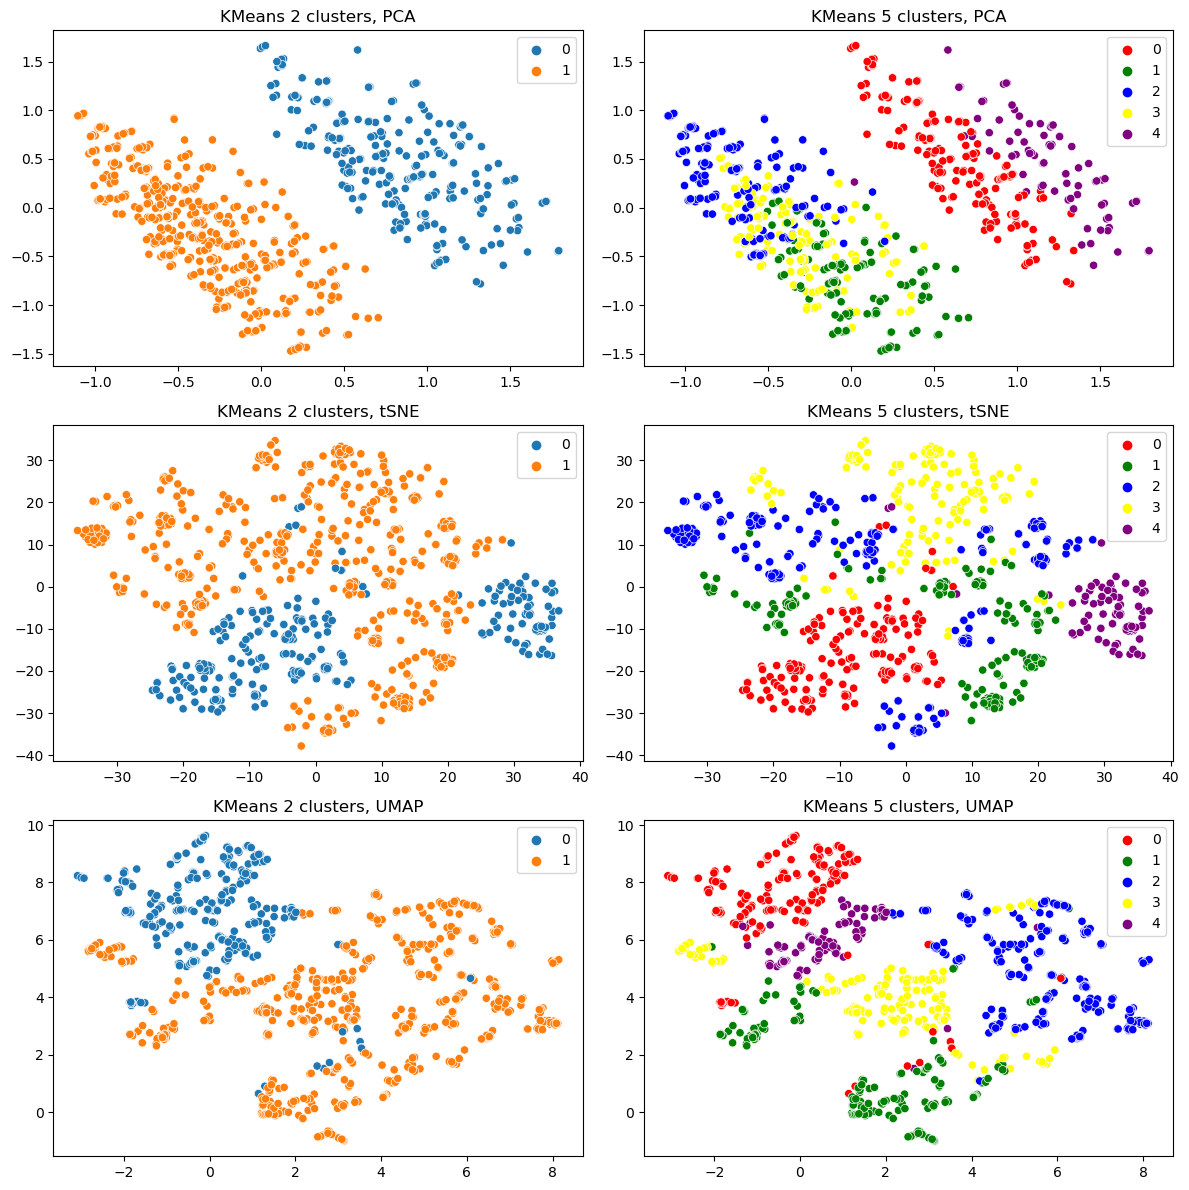

In [36]:
my_palette = ['red', 'green', 'blue', 'yellow', 'purple']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
ax = axes[0, 0]
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=kmeans_2cl.labels_, ax=ax)
ax.set_title('KMeans 2 clusters, PCA')
ax = axes[0, 1]
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=kmeans_5cl.labels_, palette=my_palette, ax=ax)
ax.set_title('KMeans 5 clusters, PCA')
ax = axes[1, 0]
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=kmeans_2cl.labels_, ax=ax)
ax.set_title('KMeans 2 clusters, tSNE')
ax = axes[1, 1]
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=kmeans_5cl.labels_, palette=my_palette, ax=ax)
ax.set_title('KMeans 5 clusters, tSNE')
ax = axes[2, 0]
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=kmeans_2cl.labels_, ax=ax)
ax.set_title('KMeans 2 clusters, UMAP')
ax = axes[2, 1]
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=kmeans_5cl.labels_, palette=my_palette, ax=ax)
ax.set_title('KMeans 5 clusters, UMAP')
plt.tight_layout()

Займемся интерпретацией.  

In [37]:
df_ = pd.concat((df[num_cols], ohe_df), axis=1)

##### 2 кластера

In [38]:
cl0 = df_.iloc[np.where(kmeans_2cl.labels_ == 0)].mean().values
cl1 = df_.iloc[np.where(kmeans_2cl.labels_ == 1)].mean().values
df_clusters = pd.DataFrame(data=np.column_stack([cl0, cl1]),\
                           columns=['Cluster 0', 'Cluster 1'],\
                           index=df_.iloc[np.where(kmeans_2cl.labels_ == 0)].mean().index)
df_clusters

,Cluster 0,Cluster 1
Age,32.803226,36.778261
Credit amount,2877.774194,3448.040580
Duration,19.438710,21.560870
Sex_female,1.000000,0.000000
Sex_male,0.000000,1.000000
Job_highly skilled,0.119355,0.160870
Job_skilled,0.635484,0.627536
Job_unskilled non-resident,0.038710,0.014493
Job_unskilled resident,0.206452,0.197101
Housing_free,0.061290,0.128986


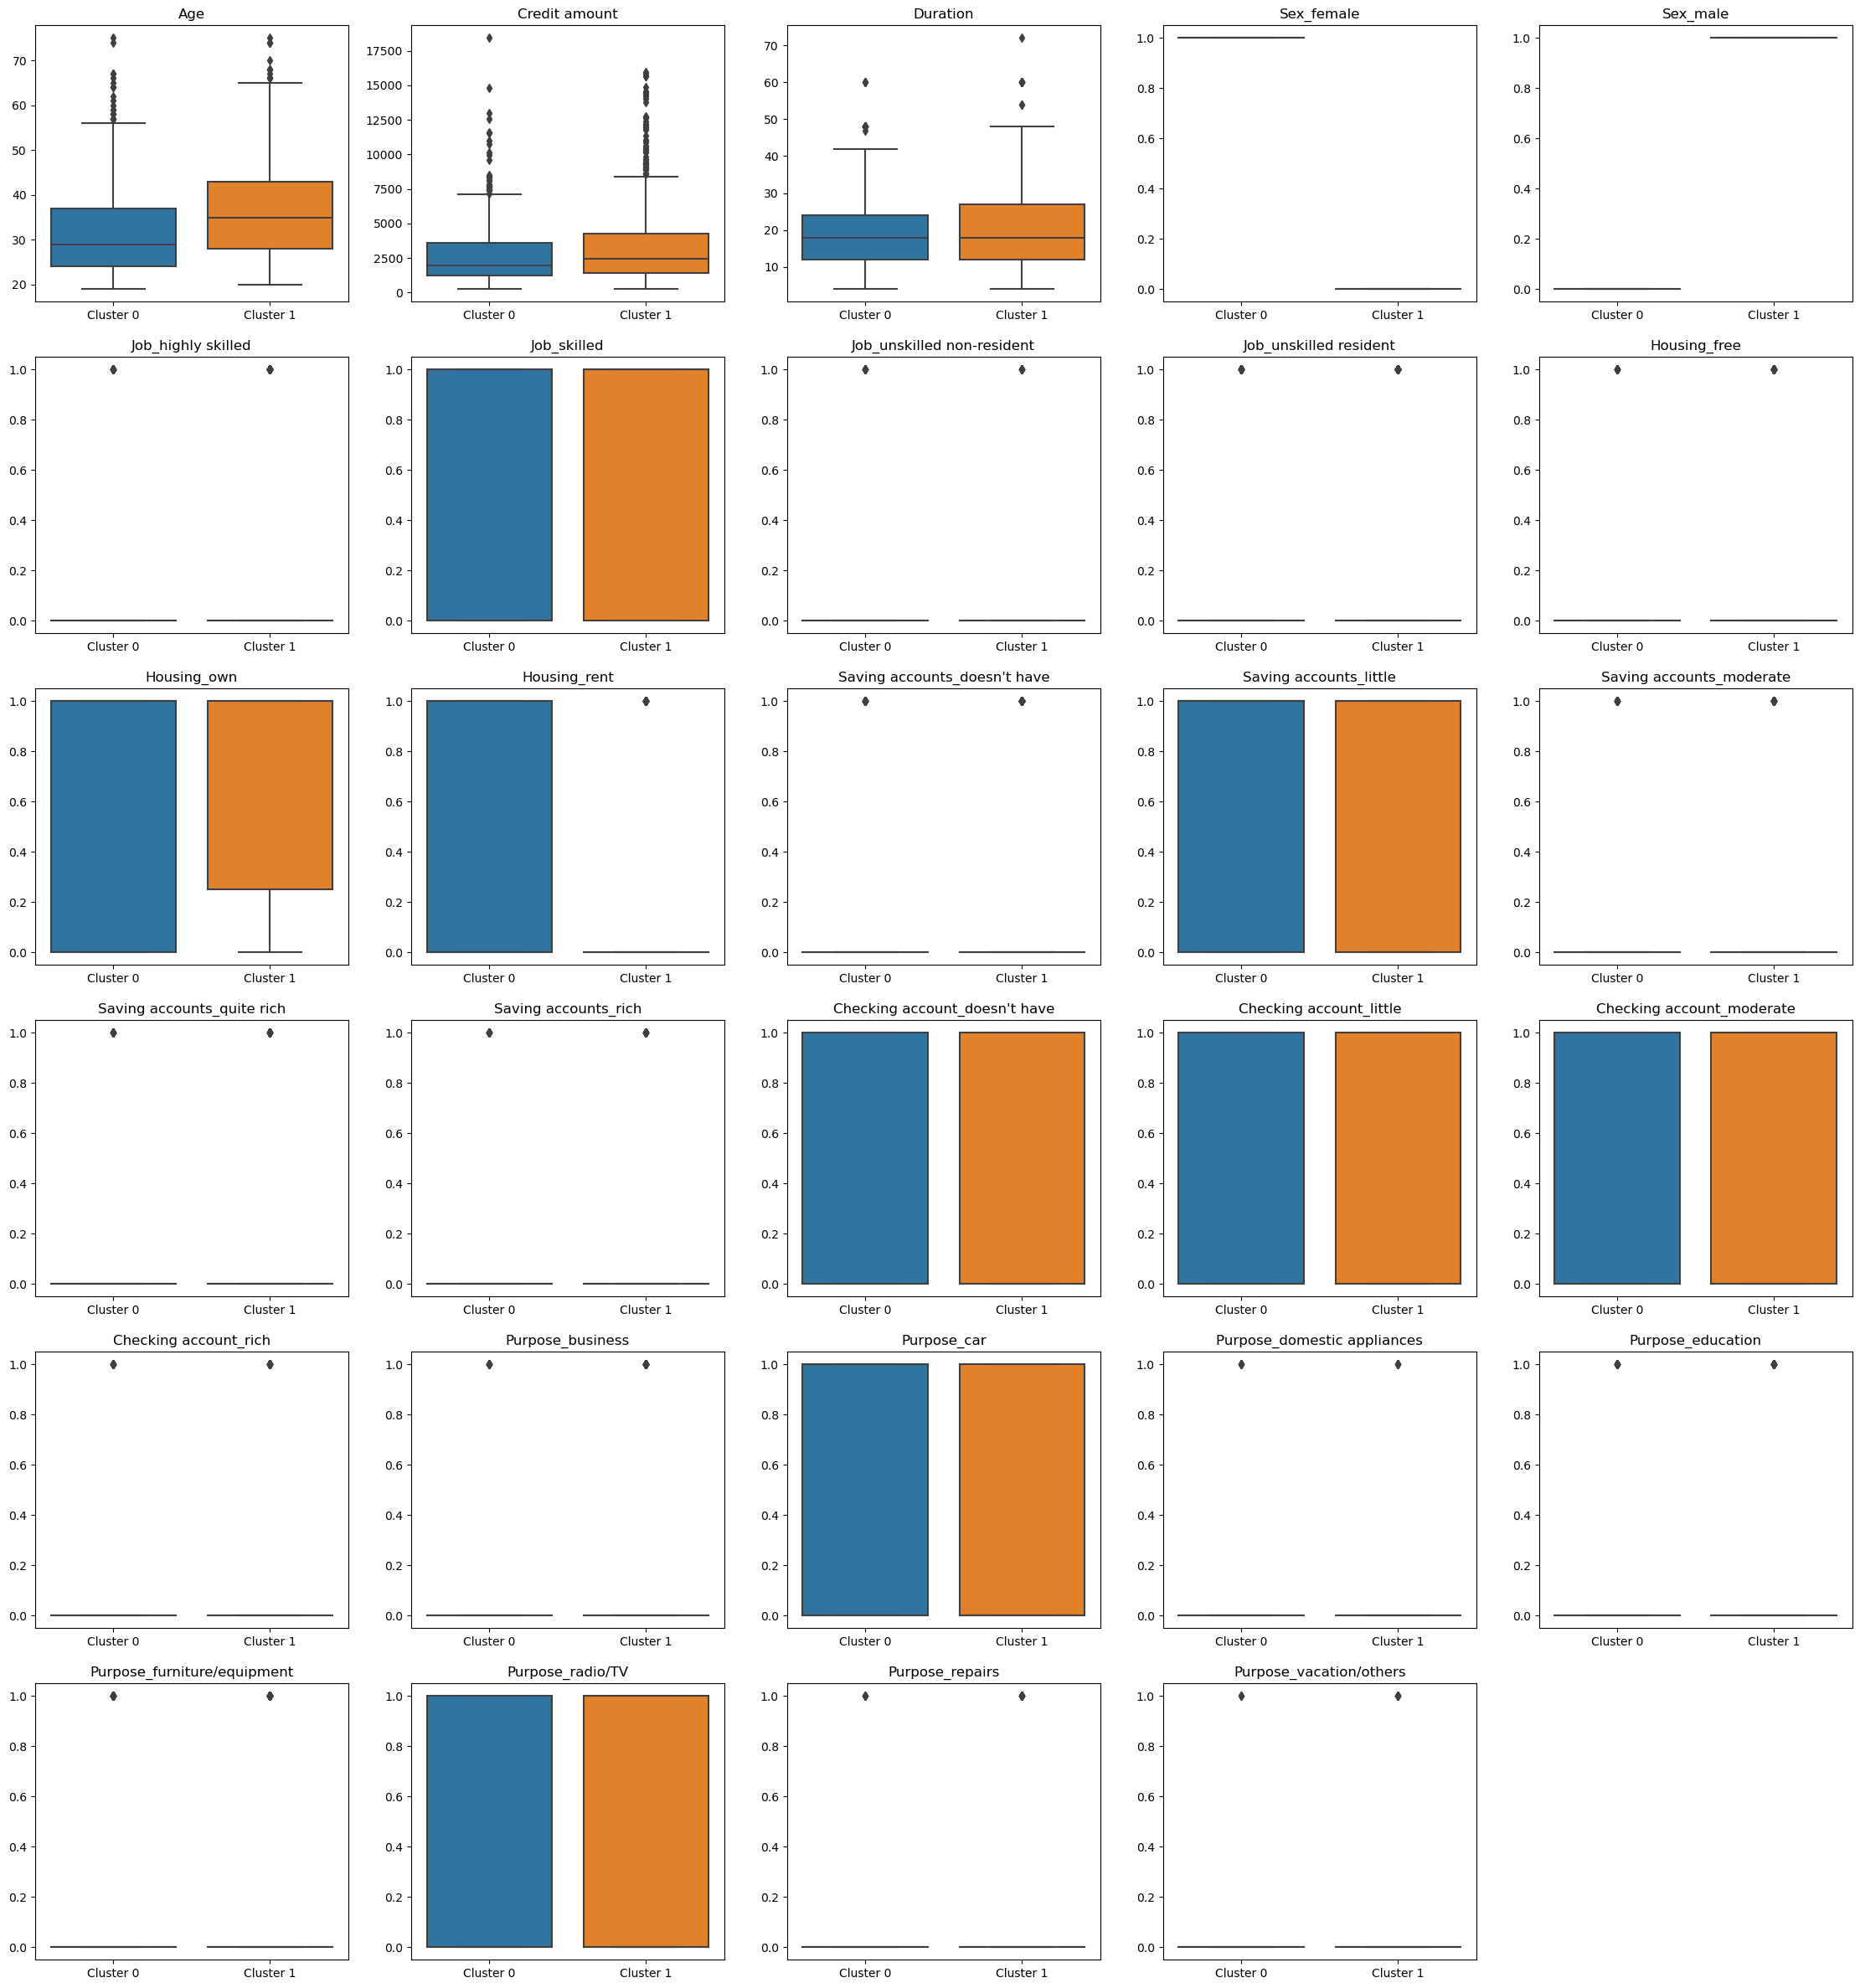

In [39]:
plt.figure(figsize=(28, 30))

for i_col in range(len(df_.columns)):
    
    plt.subplot(6, 5, i_col+1)
    
    df_test = pd.DataFrame({'Cluster 0': df_[df_.columns[i_col]].iloc[np.where(kmeans_2cl.labels_ == 0)],\
                            'Cluster 1': df_[df_.columns[i_col]].iloc[np.where(kmeans_2cl.labels_ == 1)]})
    
    sns.boxplot(data=df_test)
    plt.title(df_.columns[i_col])
    
plt.show()

2 кластера - это мужчины и женщины. В остальном признаки очень схожи. Много пользы такая модель не принесет, для группировки клиентов по полу машинное обучение не обязательно.  

##### 5 кластеров

In [40]:
cl0 = df_.iloc[np.where(kmeans_5cl.labels_ == 0)].mean().values
cl1 = df_.iloc[np.where(kmeans_5cl.labels_ == 1)].mean().values
cl2 = df_.iloc[np.where(kmeans_5cl.labels_ == 2)].mean().values
cl3 = df_.iloc[np.where(kmeans_5cl.labels_ == 3)].mean().values
cl4 = df_.iloc[np.where(kmeans_5cl.labels_ == 4)].mean().values
df_clusters = pd.DataFrame(data=np.column_stack([cl0, cl1, cl2, cl3, cl4]),\
                           columns=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],\
                           index=df_.iloc[np.where(kmeans_5cl.labels_ == 0)].mean().index)
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Age,34.850467,37.678392,37.881295,34.566038,28.154639
Credit amount,2904.397196,3381.030151,3310.169065,3690.938679,2826.659794
Duration,19.528037,21.768844,20.618705,22.589623,19.288660
Sex_female,1.000000,0.000000,0.000000,0.000000,0.989691
Sex_male,0.000000,1.000000,1.000000,1.000000,0.010309
Job_highly skilled,0.130841,0.155779,0.154676,0.174528,0.092784
Job_skilled,0.621495,0.603015,0.665468,0.599057,0.670103
Job_unskilled non-resident,0.032710,0.015075,0.000000,0.033019,0.051546
Job_unskilled resident,0.214953,0.226131,0.179856,0.193396,0.185567
Housing_free,0.084112,0.190955,0.100719,0.108491,0.010309


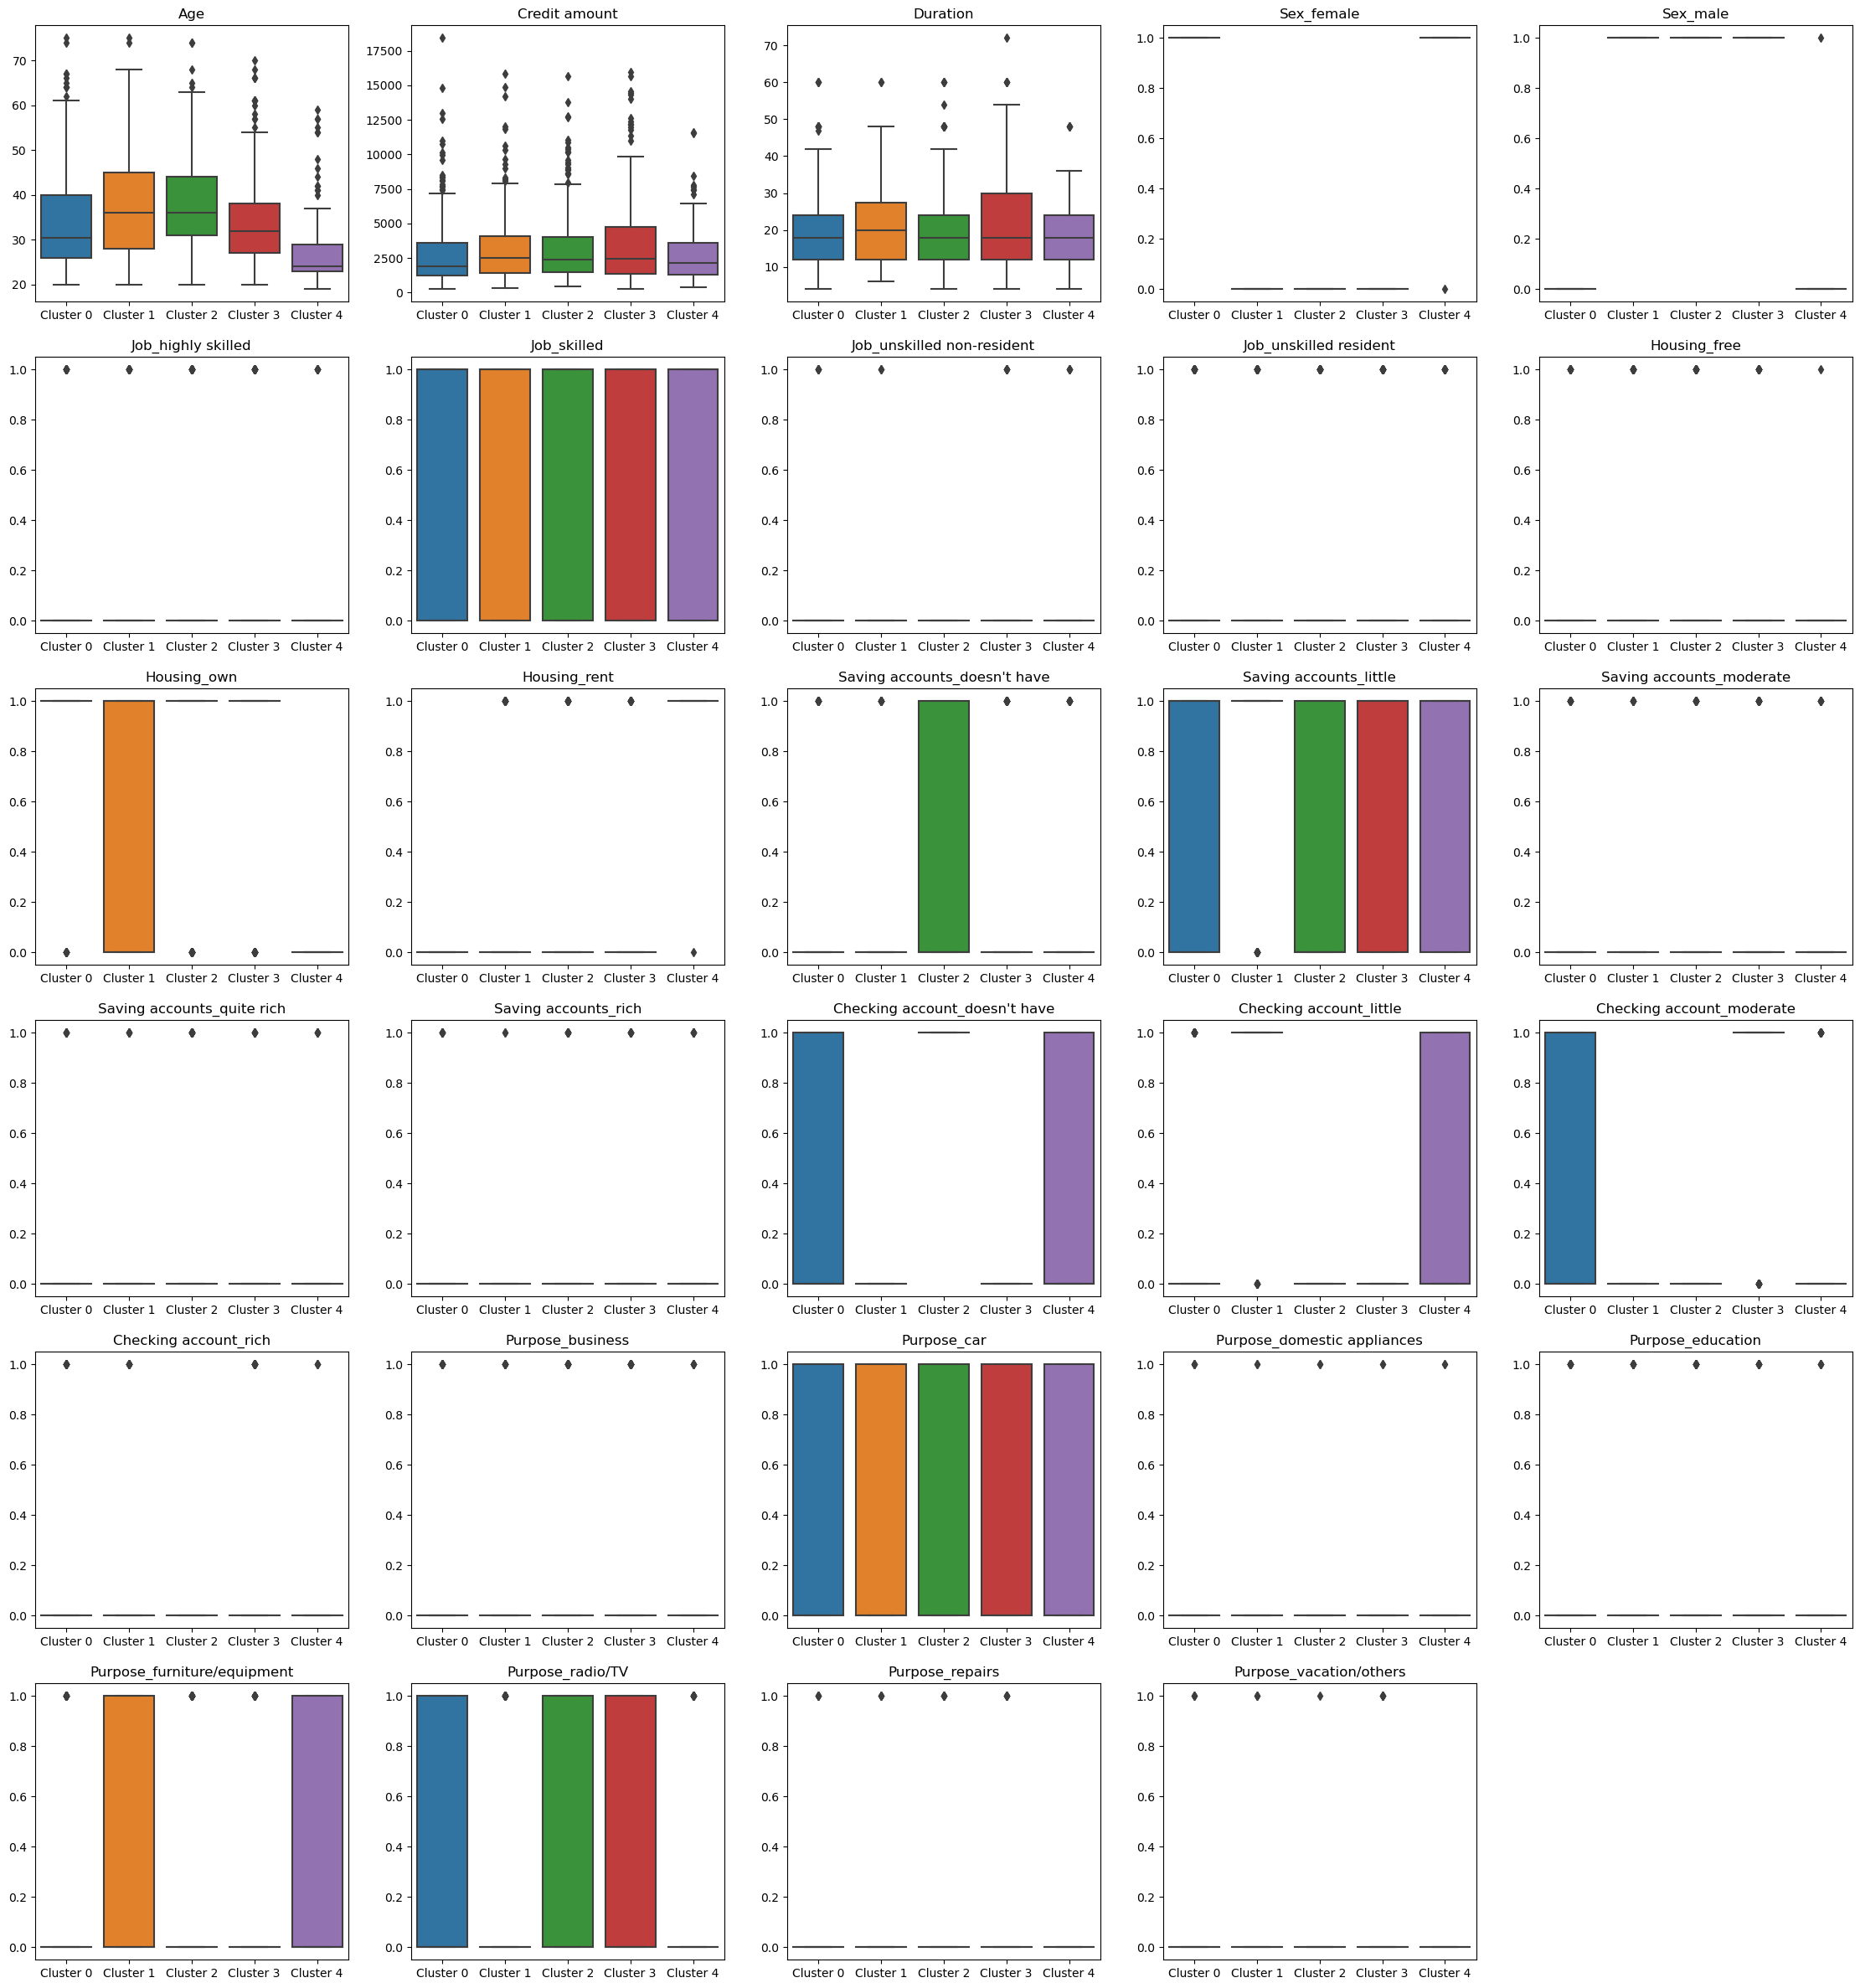

In [41]:
plt.figure(figsize=(28, 30))

for i_col in range(len(df_.columns)):
    
    plt.subplot(6, 5, i_col+1)
    
    df_test = pd.DataFrame({'Cluster 0': df_[df_.columns[i_col]].iloc[np.where(kmeans_5cl.labels_ == 0)],\
                            'Cluster 1': df_[df_.columns[i_col]].iloc[np.where(kmeans_5cl.labels_ == 1)],\
                            'Cluster 2': df_[df_.columns[i_col]].iloc[np.where(kmeans_5cl.labels_ == 2)],\
                            'Cluster 3': df_[df_.columns[i_col]].iloc[np.where(kmeans_5cl.labels_ == 3)],\
                            'Cluster 4': df_[df_.columns[i_col]].iloc[np.where(kmeans_5cl.labels_ == 4)]})
    
    sns.boxplot(data=df_test)
    plt.title(df_.columns[i_col])
    
plt.show()

3 кластера мужчин и 2 кластера женщин.  

**Женщины**:  
- дипломированный специалист, снимает жилье, у большей части представителей мало отложенных денег, состояние расчетного счета в равных долях делится между отсутвием, малым и средним количеством денег, основная цель кредита - мебель  
- дипломированный специалист, собственное жилье, у большей части представителей мало отложенных денег, состояние расчетного счета в равных долях делится между отсутвием, малым и средним количеством денег, основная цель кредита - техника  

**Мужчины:**  
- дипломированный специалист, собственное жилье, у большей части представителей мало отложенных денег, мало денег на расчетном счете, чаще берут кредит на машину или мебель  
- дипломированный специалист, собственное жилье, у половины представителей мало отложенных денег, нет расчетного счета, чаще берут кредит на машину или технику  
- дипломированный специалист, собственное жилье, у половины представителей мало отложенных денег, среднее количество денег на расчетном счете, чаще берут кредит на машину или технику    

### Hierarchical

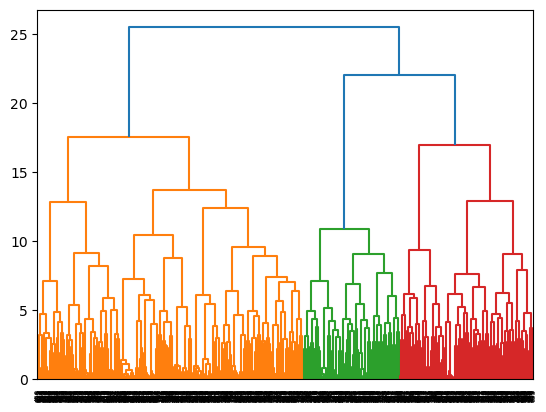

In [42]:
linkage_ = linkage(df_processed, method='ward')
dendrogram_ = dendrogram(linkage_)

Дендрограмма показывает, что тут либо 3, либо 5 кластеров.  
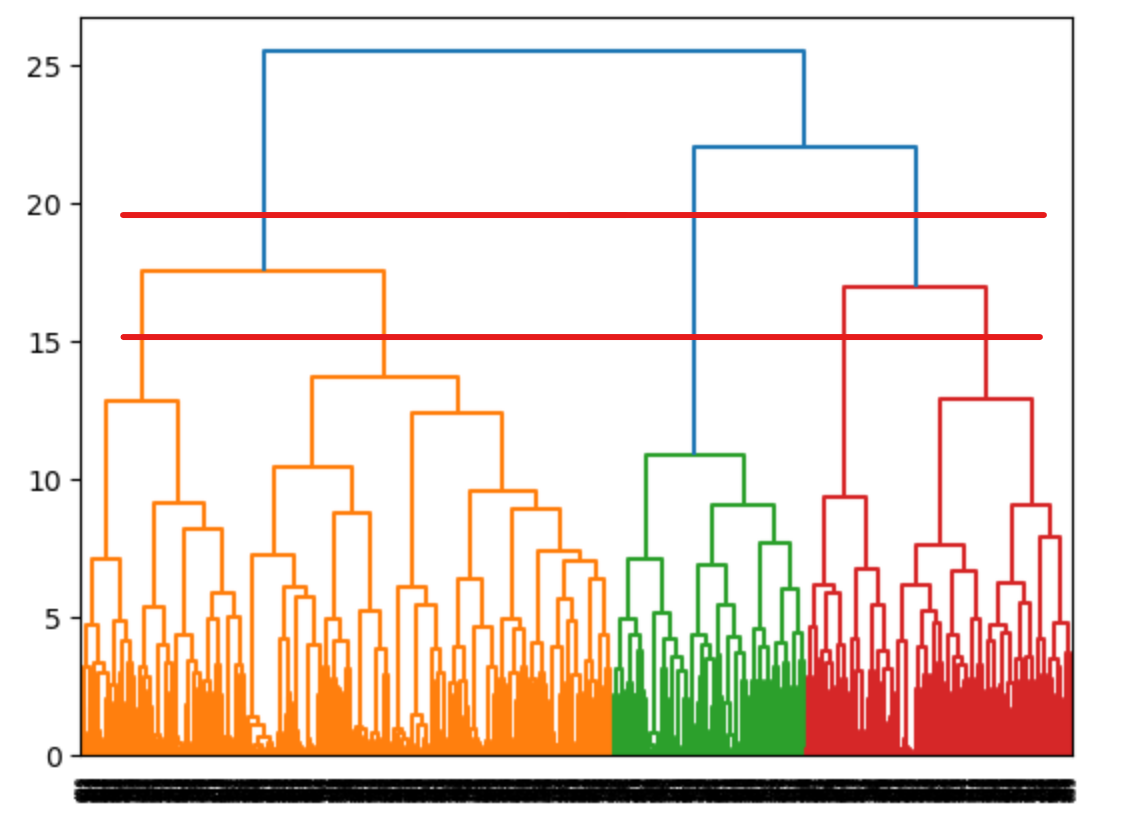

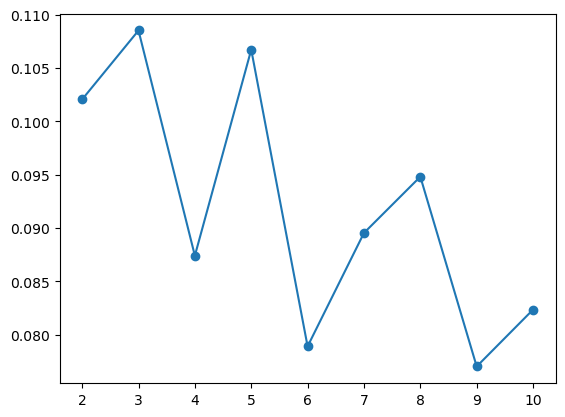

In [43]:
silhouette_score_plot(df_processed, 'hierarchical')

По силуэту здесь тоже 3 или 5 кластеров.  

In [44]:
hierarchical_clustering_3cl = AgglomerativeClustering(n_clusters=3).fit(df_processed)
hierarchical_clustering_5cl = AgglomerativeClustering(n_clusters=5).fit(df_processed)

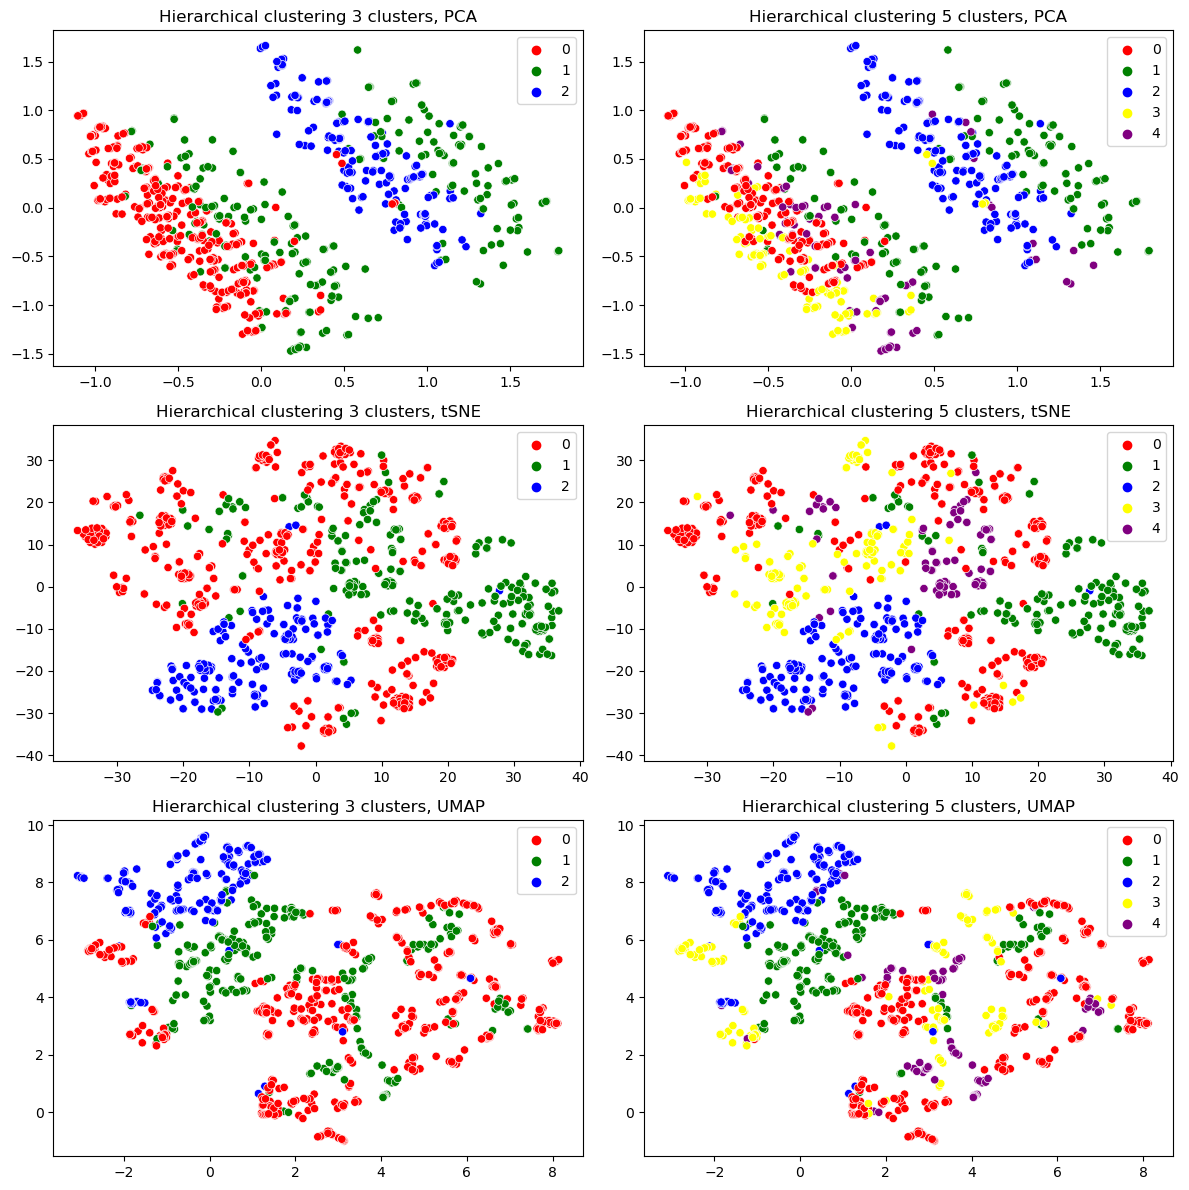

In [45]:
my_palette = ['red', 'green', 'blue', 'yellow', 'purple']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
ax = axes[0, 0]
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=hierarchical_clustering_3cl.labels_, palette=my_palette[:3], ax=ax)
ax.set_title('Hierarchical clustering 3 clusters, PCA')
ax = axes[0, 1]
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=hierarchical_clustering_5cl.labels_, palette=my_palette, ax=ax)
ax.set_title('Hierarchical clustering 5 clusters, PCA')
ax = axes[1, 0]
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=hierarchical_clustering_3cl.labels_, palette=my_palette[:3], ax=ax)
ax.set_title('Hierarchical clustering 3 clusters, tSNE')
ax = axes[1, 1]
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=hierarchical_clustering_5cl.labels_, palette=my_palette, ax=ax)
ax.set_title('Hierarchical clustering 5 clusters, tSNE')
ax = axes[2, 0]
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=hierarchical_clustering_3cl.labels_, palette=my_palette[:3], ax=ax)
ax.set_title('Hierarchical clustering 3 clusters, UMAP')
ax = axes[2, 1]
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=hierarchical_clustering_5cl.labels_, palette=my_palette, ax=ax)
ax.set_title('Hierarchical clustering 5 clusters, UMAP')
plt.tight_layout()

##### 3 кластера

In [46]:
cl0 = df_.iloc[np.where(hierarchical_clustering_3cl.labels_ == 0)].mean().values
cl1 = df_.iloc[np.where(hierarchical_clustering_3cl.labels_ == 1)].mean().values
cl2 = df_.iloc[np.where(hierarchical_clustering_3cl.labels_ == 2)].mean().values
df_clusters = pd.DataFrame(data=np.column_stack([cl0, cl1, cl2]),\
                           columns=['Cluster 0', 'Cluster 1', 'Cluster 2'],\
                           index=df_.iloc[np.where(hierarchical_clustering_3cl.labels_ == 0)].mean().index)
df_clusters

,Cluster 0,Cluster 1,Cluster 2
Age,36.353818,35.308550,33.639175
Credit amount,3213.540037,3776.442379,2730.536082
Duration,20.828678,22.245353,19.247423
Sex_female,0.011173,0.412639,0.994845
Sex_male,0.988827,0.587361,0.005155
Job_highly skilled,0.143389,0.182156,0.113402
Job_skilled,0.623836,0.624535,0.654639
Job_unskilled non-resident,0.014898,0.029740,0.030928
Job_unskilled resident,0.217877,0.163569,0.201031
Housing_free,0.020484,0.342007,0.025773


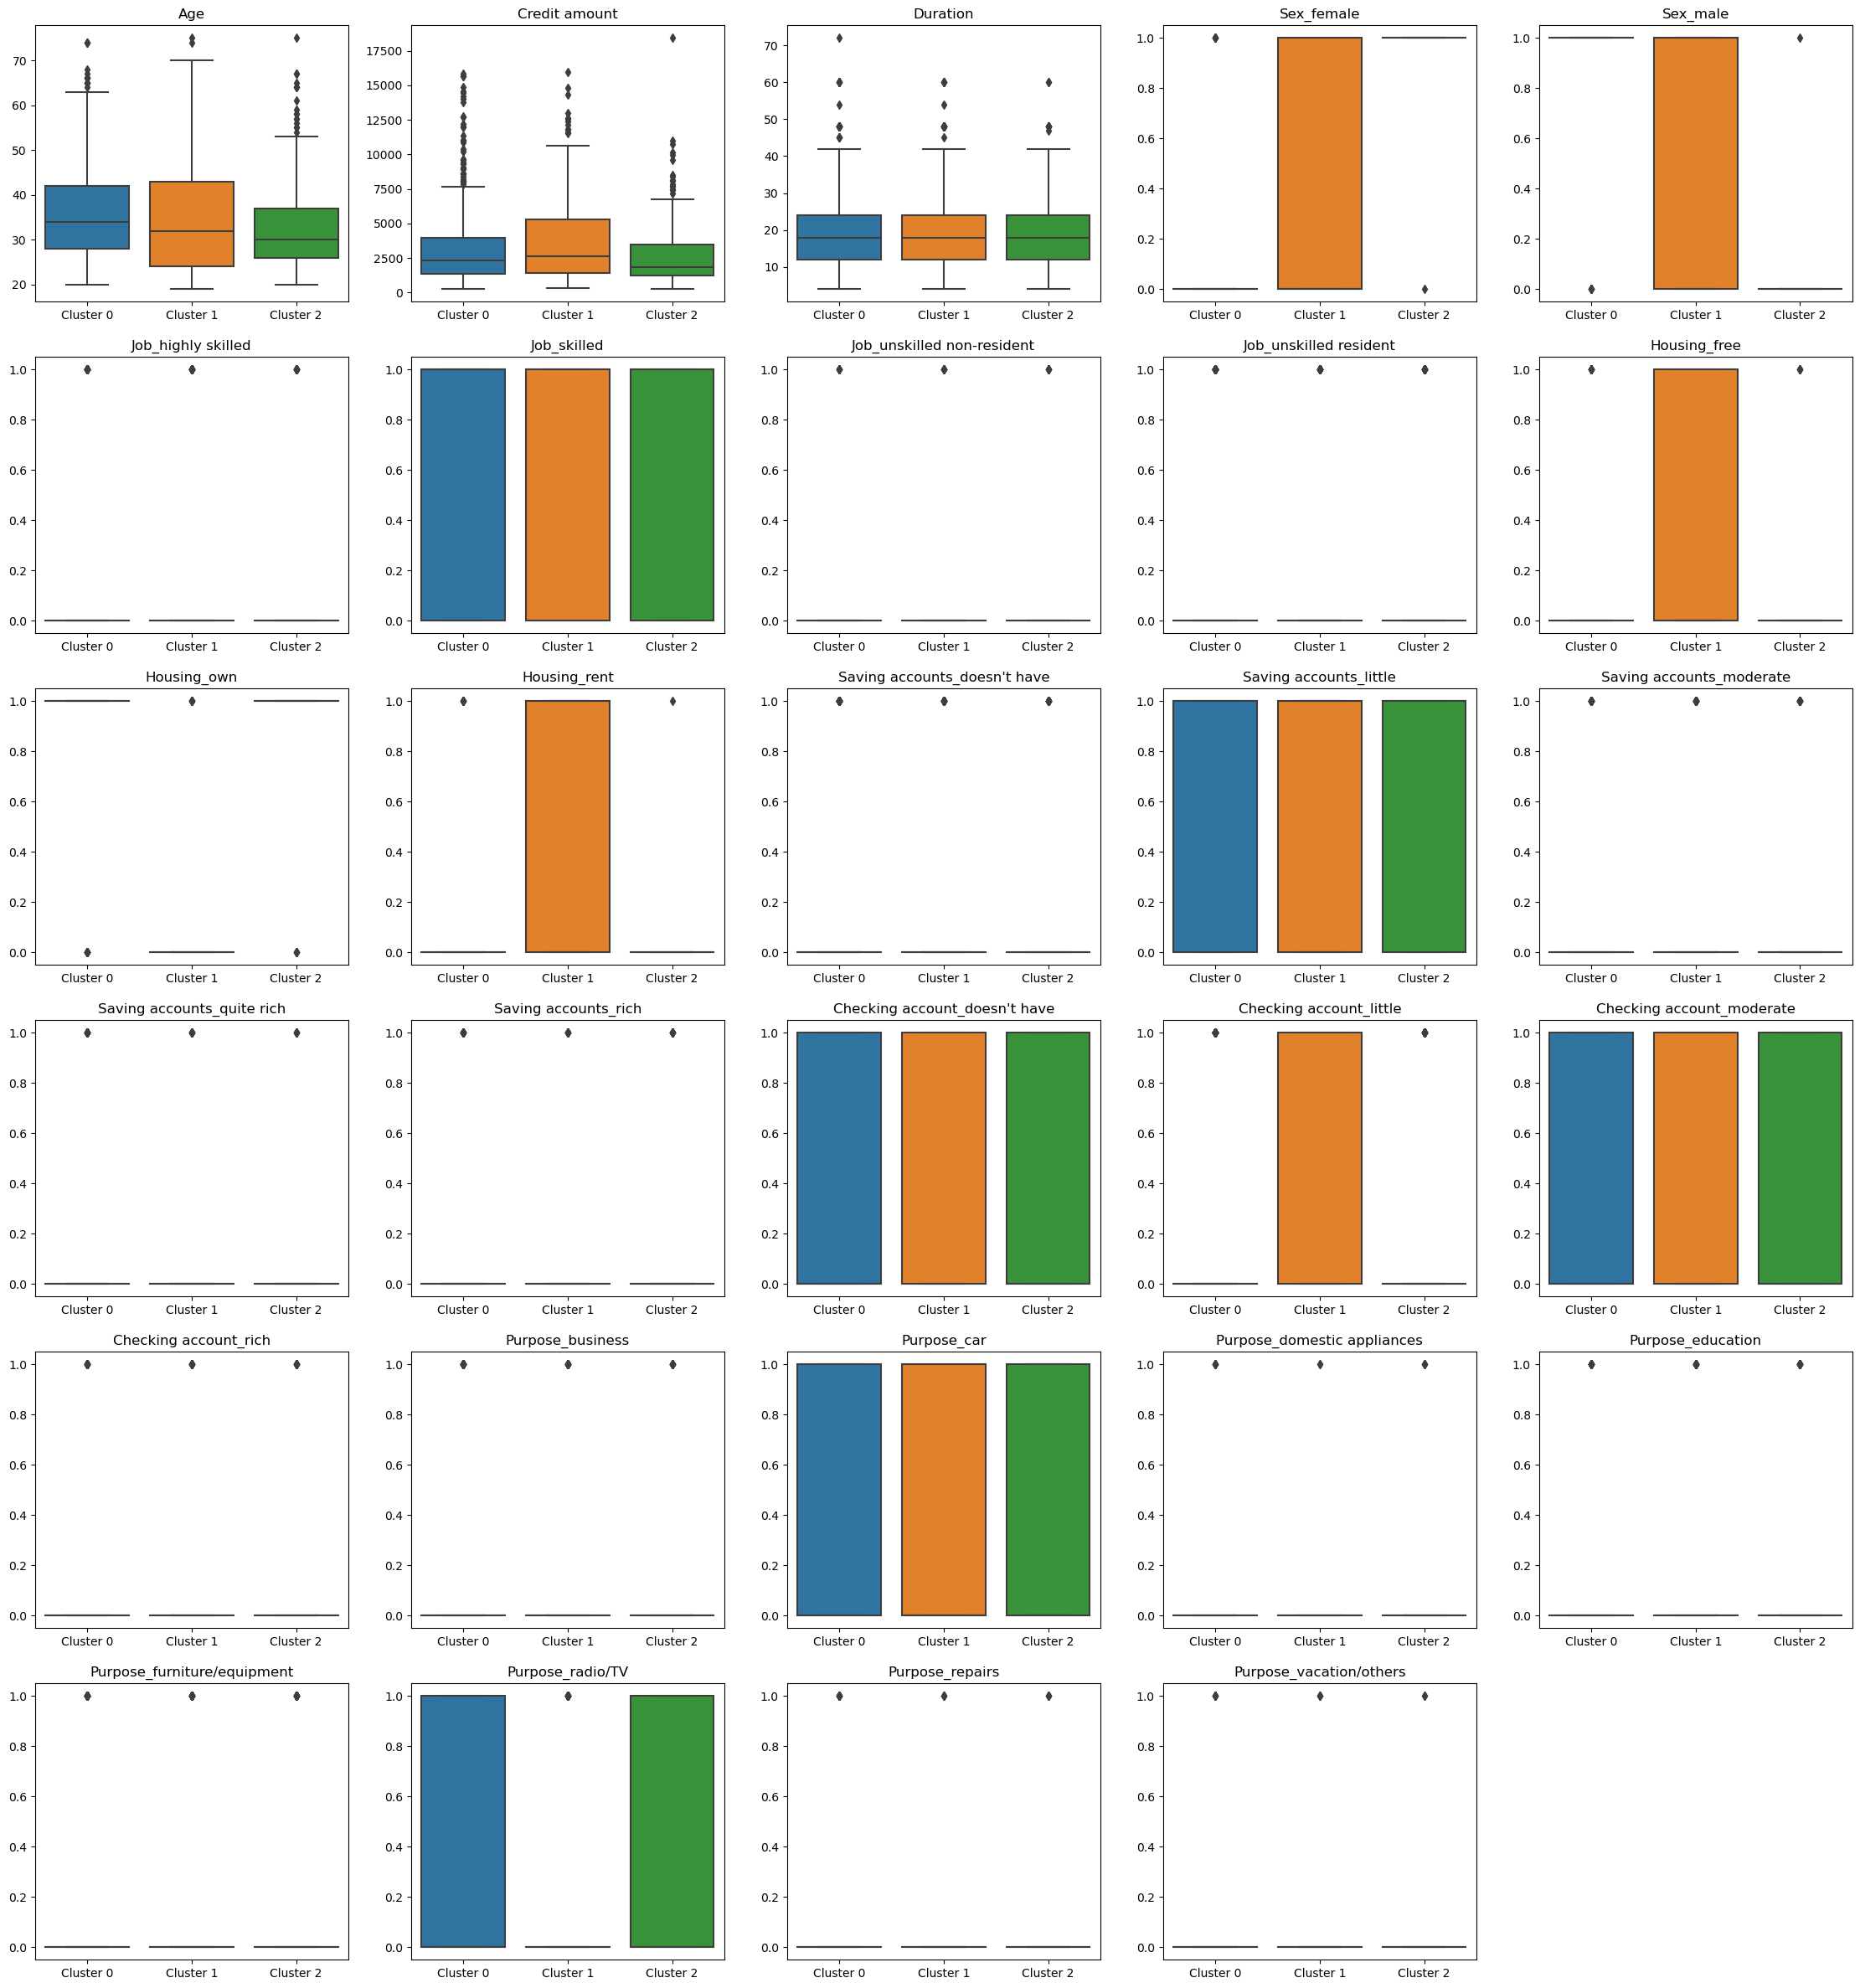

In [47]:
plt.figure(figsize=(28, 30))

for i_col in range(len(df_.columns)):
    
    plt.subplot(6, 5, i_col+1)
    
    df_test = pd.DataFrame({'Cluster 0': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_3cl.labels_ == 0)],\
                            'Cluster 1': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_3cl.labels_ == 1)],\
                            'Cluster 2': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_3cl.labels_ == 2)]})
    
    sns.boxplot(data=df_test)
    plt.title(df_.columns[i_col])
    
plt.show()

Мужчины, женщины и 50/50.  

**Мужчины:**  
- Дипломированный специалист, свой дом, мало отложенных денег, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника или мебель  

**Женщины:**  
- Меньше сумма кредита, дипломированный специалист, свой дом, мало отложенных денег, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника или мебель  

**50/50:**  
- Дипломированный специалист, жилье бесплатное или арендованное, мало отложенных денег, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника или мебель  

##### 5 кластеров

In [48]:
cl0 = df_.iloc[np.where(hierarchical_clustering_5cl.labels_ == 0)].mean().values
cl1 = df_.iloc[np.where(hierarchical_clustering_5cl.labels_ == 1)].mean().values
cl2 = df_.iloc[np.where(hierarchical_clustering_5cl.labels_ == 2)].mean().values
cl3 = df_.iloc[np.where(hierarchical_clustering_5cl.labels_ == 3)].mean().values
cl4 = df_.iloc[np.where(hierarchical_clustering_5cl.labels_ == 4)].mean().values
df_clusters = pd.DataFrame(data=np.column_stack([cl0, cl1, cl2, cl3, cl4]),\
                           columns=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],\
                           index=df_.iloc[np.where(hierarchical_clustering_5cl.labels_ == 0)].mean().index)
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Age,35.786486,30.780899,33.639175,37.610778,44.164835
Credit amount,3078.867568,3077.752809,2730.536082,3511.916168,5143.109890
Duration,21.883784,19.123596,19.247423,18.491018,28.351648
Sex_female,0.000000,0.544944,0.994845,0.035928,0.153846
Sex_male,1.000000,0.455056,0.005155,0.964072,0.846154
Job_highly skilled,0.048649,0.112360,0.113402,0.353293,0.318681
Job_skilled,0.897297,0.629213,0.654639,0.017964,0.615385
Job_unskilled non-resident,0.016216,0.028090,0.030928,0.011976,0.032967
Job_unskilled resident,0.037838,0.230337,0.201031,0.616766,0.032967
Housing_free,0.018919,0.011236,0.025773,0.023952,0.989011


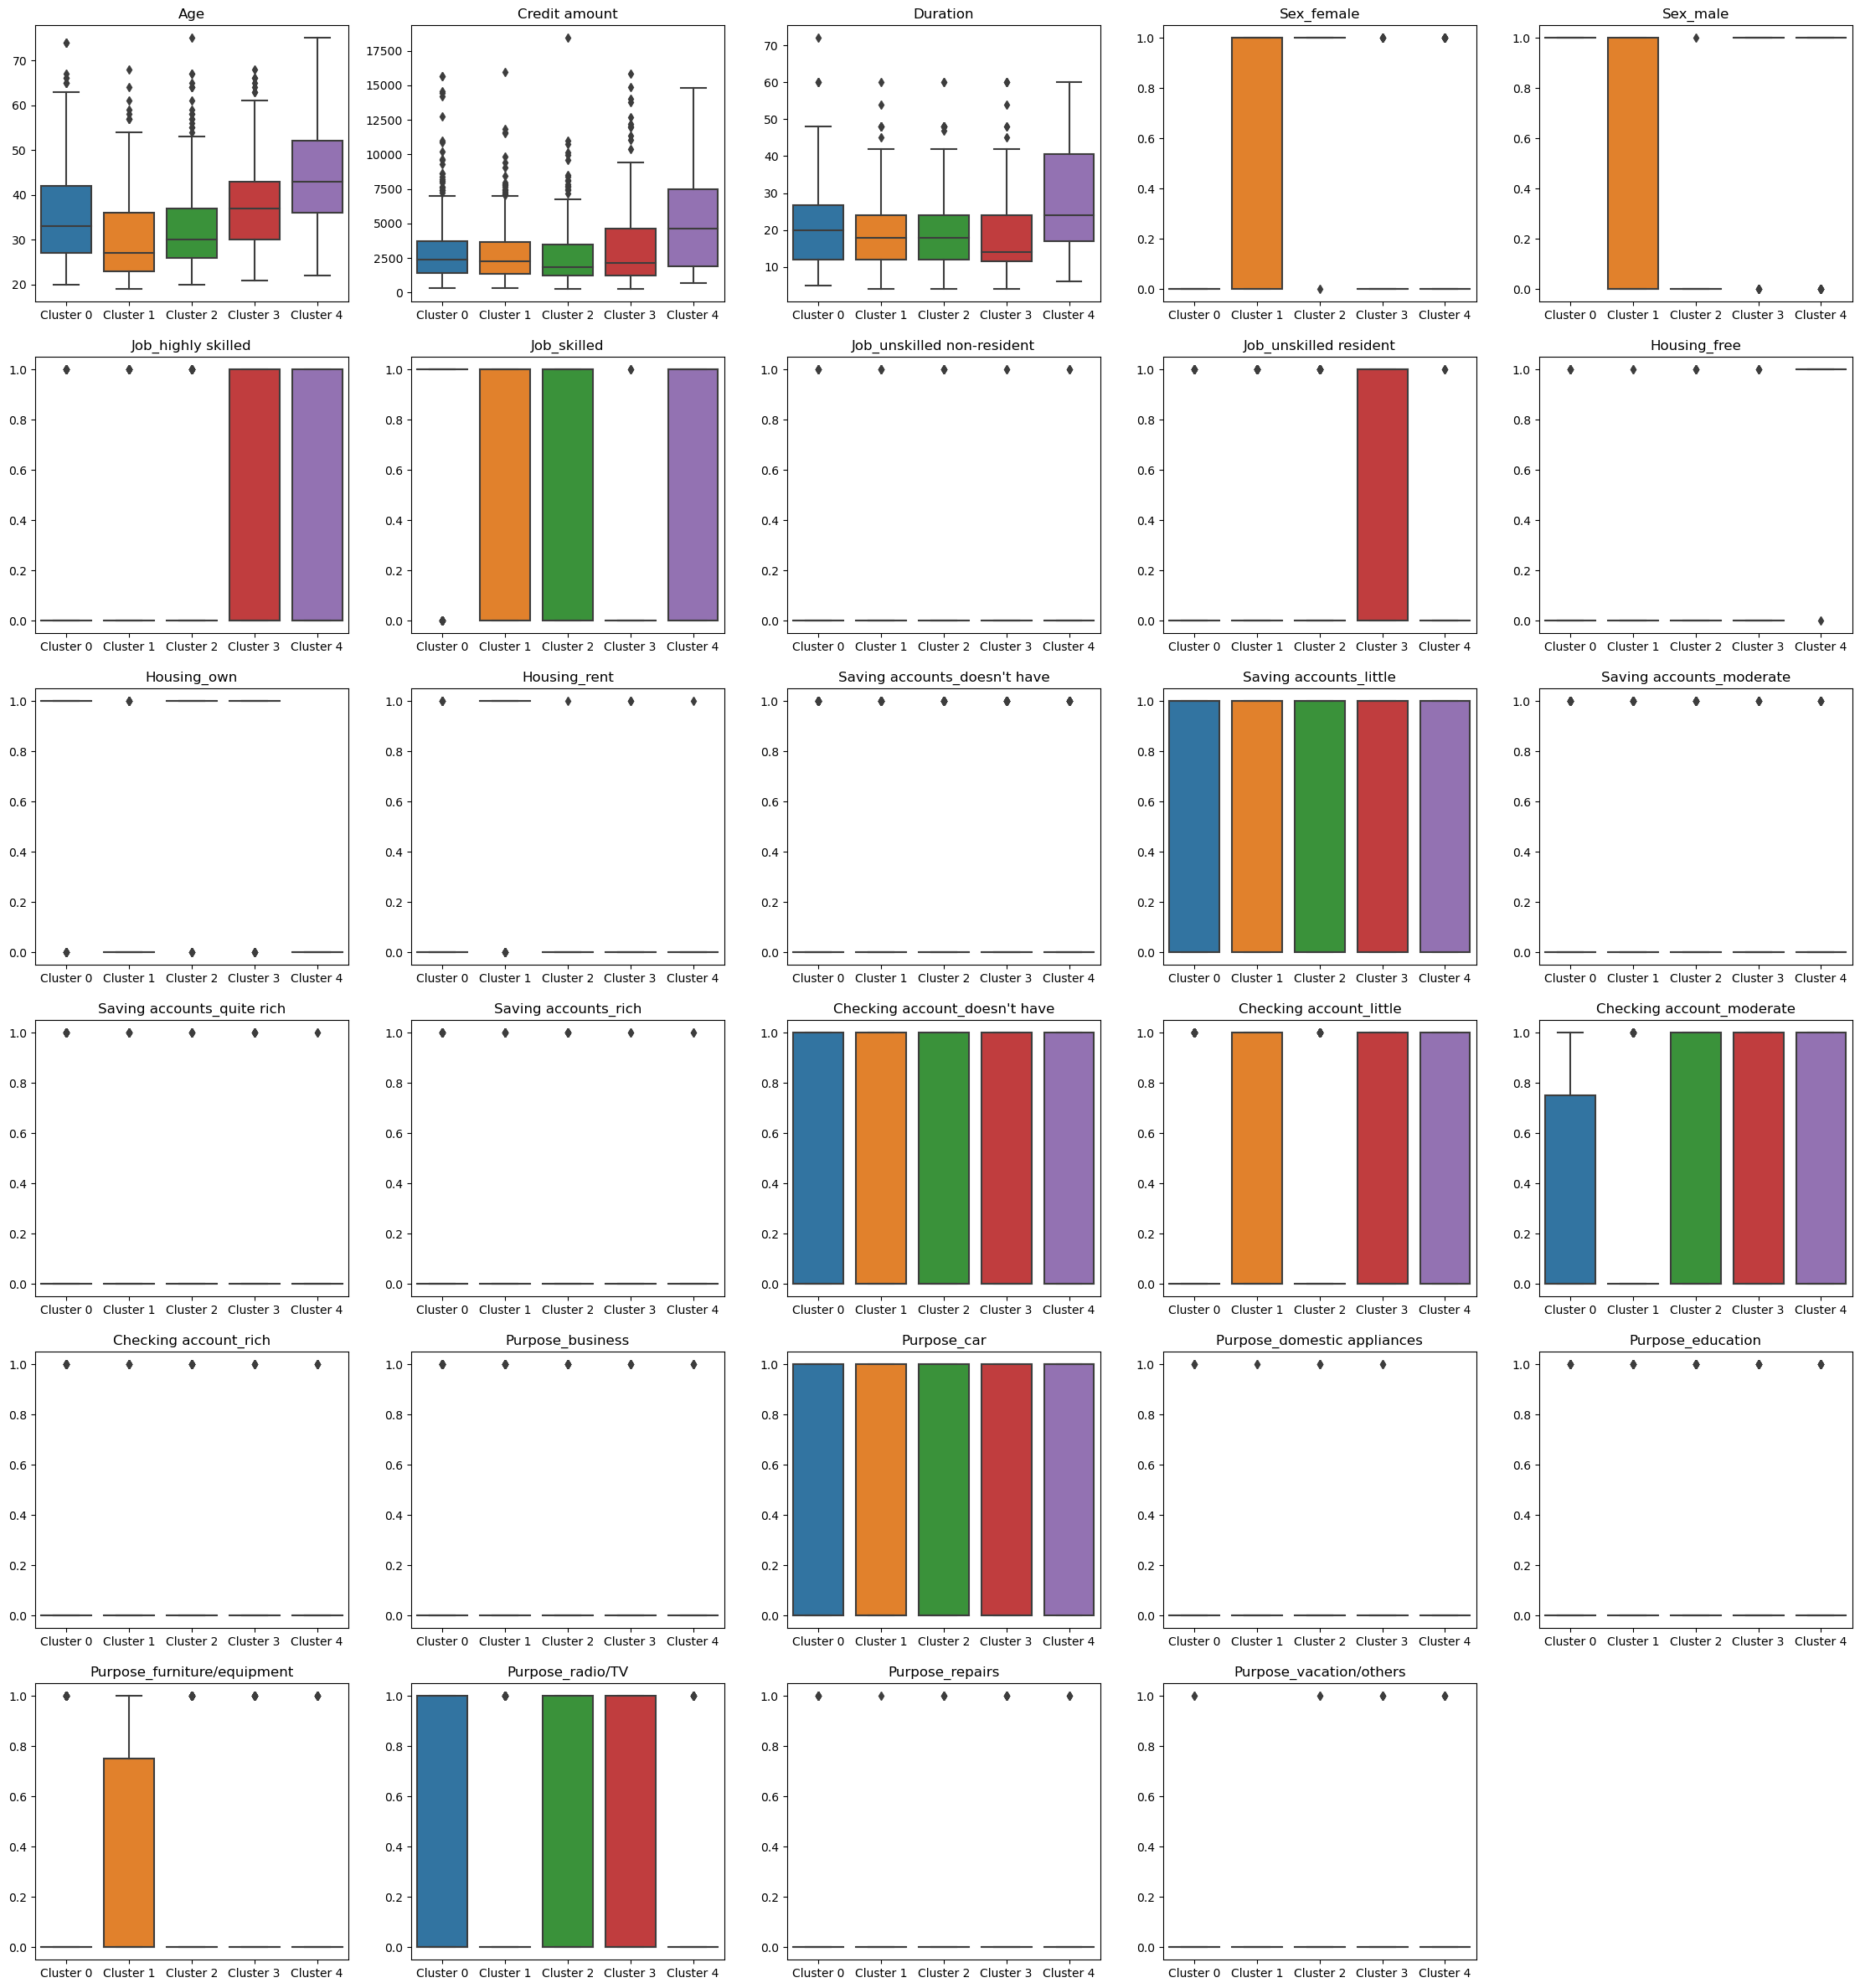

In [49]:
plt.figure(figsize=(28, 30))

for i_col in range(len(df_.columns)):
    
    plt.subplot(6, 5, i_col+1)
    
    df_test = pd.DataFrame({'Cluster 0': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_5cl.labels_ == 0)],\
                            'Cluster 1': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_5cl.labels_ == 1)],\
                            'Cluster 2': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_5cl.labels_ == 2)],\
                            'Cluster 3': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_5cl.labels_ == 3)],\
                            'Cluster 4': df_[df_.columns[i_col]].iloc[np.where(hierarchical_clustering_5cl.labels_ == 4)]})
    
    sns.boxplot(data=df_test)
    plt.title(df_.columns[i_col])
    
plt.show()

3 кластера мужчин, 1 кластер женщин и 50/50.  

**Мужчины:**  
- Дипломированный специалист, свой дом, мало отложенных денег, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника или мебель  
- Высококвалифицированный специалист или отсутсвует образование, свой дом, мало отложенных денег, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника или мебель  
- Постарше, больше сумма кредита, дипломированный или высококвалифицированный специалист, бесплатное жилье, мало отложенных денег, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника, мебель или образование  

**Женщины:**  
- Меньше сумма кредита, дипломированный специалист, свой дом, мало отложенных денег, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника или мебель    

**50/50:**  
- Дипломированный специалист, арендует жилье, мало отложенных денег или отсутствие накопительного счета, р/с отсутствует, реже на нем малое или среднее количество денег, основная цель кредита - машина, техника или мебель

### DBSCAN

In [50]:
dbscan = DBSCAN(eps=1, min_samples=15).fit(df_processed)
len(set(dbscan.labels_))

7

Подобрал такие параметры, чтобы кластеров было оптимальное количество.  

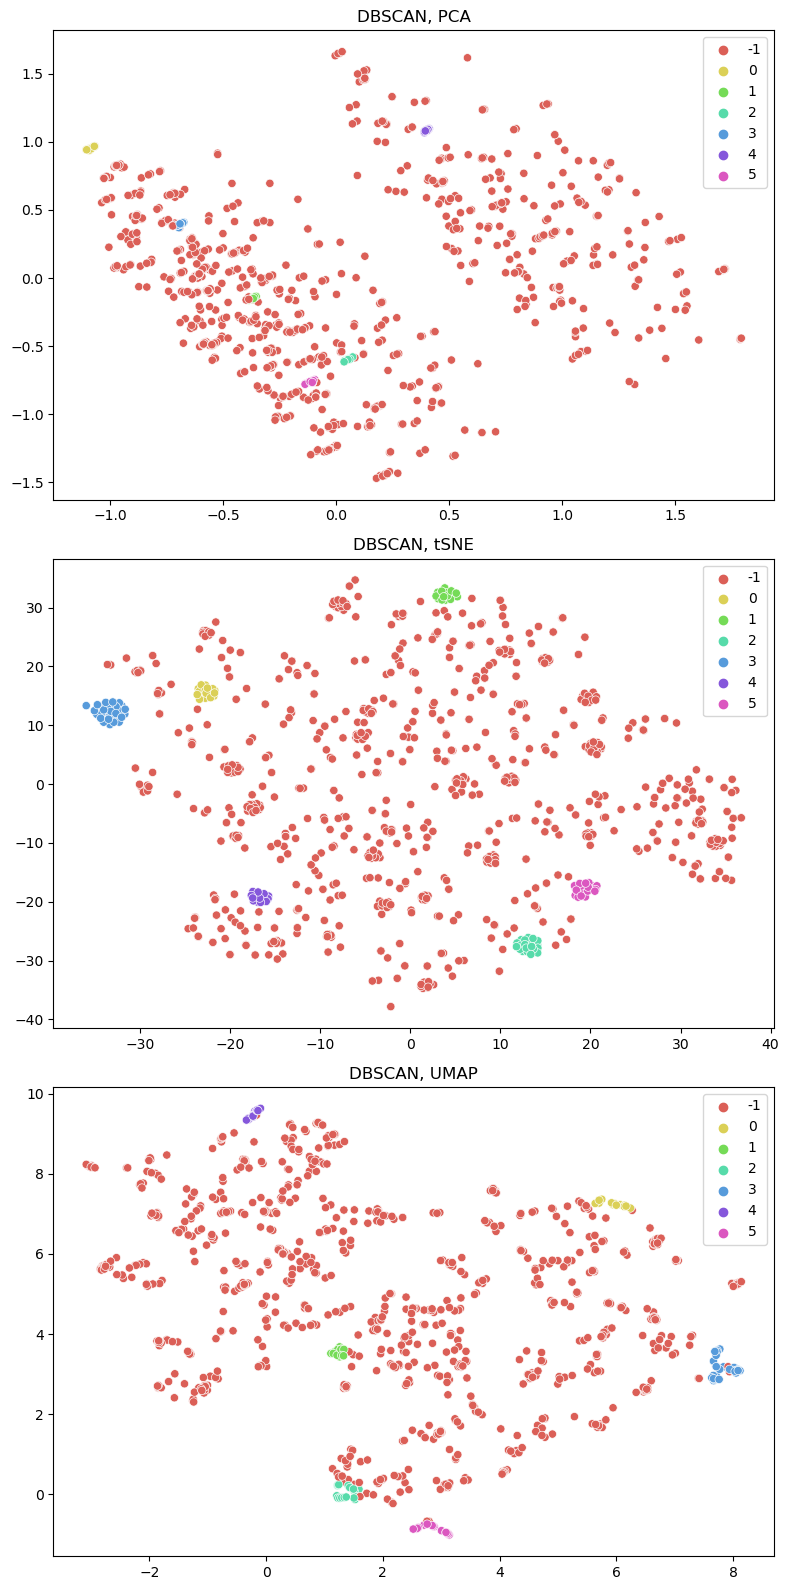

In [51]:
palette = sns.color_palette('hls', 7)

fig, axes = plt.subplots(3, 1, figsize=(8, 16))
ax = axes[0]
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=dbscan.labels_, palette=palette, ax=ax)
ax.set_title('DBSCAN, PCA')
ax = axes[1]
sns.scatterplot(x=df_tsne[:, 0], y=df_tsne[:, 1], hue=dbscan.labels_, palette=palette, ax=ax)
ax.set_title('DBSCAN, tSNE')
ax = axes[2]
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=dbscan.labels_, palette=palette, ax=ax)
ax.set_title('DBSCAN, UMAP')
plt.tight_layout()

Слишком большое количество насоздает группы, которые слабо отличаются друг от друга - значит, можно и в 1 кластер объединить. Но шума, к сожалению, получилось многовато, уже сейчас можно сделать вывод, что этот метод не окажется лучшим.  

In [52]:
noise = df_.iloc[np.where(dbscan.labels_ == -1)].mean().values
cl0 = df_.iloc[np.where(dbscan.labels_ == 0)].mean().values
cl1 = df_.iloc[np.where(dbscan.labels_ == 1)].mean().values
cl2 = df_.iloc[np.where(dbscan.labels_ == 2)].mean().values
cl3 = df_.iloc[np.where(dbscan.labels_ == 3)].mean().values
cl4 = df_.iloc[np.where(dbscan.labels_ == 4)].mean().values
cl5 = df_.iloc[np.where(dbscan.labels_ == 5)].mean().values
df_clusters = pd.DataFrame(data=np.column_stack([cl0, cl1, cl2, cl3, cl4, cl5, noise]),\
                           columns=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Noise'],\
                           index=df_.iloc[np.where(dbscan.labels_ == 0)].mean().index)
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Noise
Age,40.647059,30.8125,35.904762,34.600000,29.533333,39.842105,35.566893
Credit amount,3306.647059,2302.3125,3231.190476,2607.333333,2747.866667,3051.631579,3325.321995
Duration,25.941176,18.0625,24.142857,18.566667,19.200000,21.210526,20.882086
Sex_female,0.000000,0.0000,0.000000,0.000000,1.000000,0.000000,0.334467
Sex_male,1.000000,1.0000,1.000000,1.000000,0.000000,1.000000,0.665533
Job_highly skilled,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.167800
Job_skilled,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,0.580499
Job_unskilled non-resident,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.024943
Job_unskilled resident,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.226757
Housing_free,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.122449


Шум, 5 кластеров мужчин и 1 кластер женщин (что-то женщины не сильно отличаются друг от друга, судя по результатам всех моделей :)).  
Но глядя на эту таблицу, создается впечатление, что все кластеры содержат эталонных представителей своей группы, за исключением шума (средние значения категориальных признаков равны 1 или 0). Посмотрим, сколько сэмплов в каждом кластере.  

In [53]:
clusters_enum = range(-1, 6)
for num in clusters_enum:
    print(f'Cluster {num} has {len(df_.iloc[np.where(dbscan.labels_ == num)].values)} number of samples')

Cluster -1 has 882 number of samples
Cluster 0 has 17 number of samples
Cluster 1 has 16 number of samples
Cluster 2 has 21 number of samples
Cluster 3 has 30 number of samples
Cluster 4 has 15 number of samples
Cluster 5 has 19 number of samples


Так и есть, такой результат тоже мало полезен. Банкам незачем сидеть и ждать, пока их посетят эталонные представители какой-нибудь из групп, как и строить аналитику по этой модели. Тем более, что шанс таких встретить равен 12%.  

In [54]:
sum_clusters_count = sum([len(df_.iloc[np.where(dbscan.labels_ == num)].values) for num in clusters_enum if num != -1])
sum_clusters_count / df_.shape[0]

0.118

Попробуем построить модель с нормальными значениями гиперпараметров.  

In [55]:
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(df_processed)
len(set(dbscan.labels_))

17

In [56]:
noise = df_.iloc[np.where(dbscan.labels_ == -1)].mean().values
cl0 = df_.iloc[np.where(dbscan.labels_ == 0)].mean().values
cl1 = df_.iloc[np.where(dbscan.labels_ == 1)].mean().values
cl2 = df_.iloc[np.where(dbscan.labels_ == 2)].mean().values
cl3 = df_.iloc[np.where(dbscan.labels_ == 3)].mean().values
cl4 = df_.iloc[np.where(dbscan.labels_ == 4)].mean().values
cl5 = df_.iloc[np.where(dbscan.labels_ == 5)].mean().values
cl6 = df_.iloc[np.where(dbscan.labels_ == 6)].mean().values
cl7 = df_.iloc[np.where(dbscan.labels_ == 7)].mean().values
cl8 = df_.iloc[np.where(dbscan.labels_ == 8)].mean().values
cl9 = df_.iloc[np.where(dbscan.labels_ == 9)].mean().values
cl10 = df_.iloc[np.where(dbscan.labels_ == 10)].mean().values
cl11 = df_.iloc[np.where(dbscan.labels_ == 11)].mean().values
cl12 = df_.iloc[np.where(dbscan.labels_ == 12)].mean().values
cl13 = df_.iloc[np.where(dbscan.labels_ == 13)].mean().values
cl14 = df_.iloc[np.where(dbscan.labels_ == 14)].mean().values
cl15 = df_.iloc[np.where(dbscan.labels_ == 15)].mean().values
df_clusters = pd.DataFrame(data=np.column_stack([cl0, cl1, cl2, cl3, cl4, cl5,\
                                                 cl6, cl7, cl8, cl9, cl10, cl11,\
                                                 cl12, cl13, cl14, cl15, noise]),\
                           columns=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5',\
                                    'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11',\
                                    'Cluster 12', 'Cluster 13', 'Cluster 14', 'Cluster 15', 'Noise'],\
                           index=df_.iloc[np.where(dbscan.labels_ == 0)].mean().index)
df_clusters

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14,Cluster 15,Noise
Age,40.647059,33.500000,30.8125,35.904762,39.333333,35.068966,41.769231,29.533333,39.842105,24.818182,40.083333,31.6,40.2,31.166667,37.3,30.4,35.609883
Credit amount,3306.647059,3252.857143,2302.3125,3231.190476,2771.250000,2157.482759,3335.076923,2747.866667,3051.631579,1950.181818,1934.333333,3705.6,2582.5,1409.333333,5491.5,2883.8,3404.715215
Duration,25.941176,21.000000,18.0625,24.142857,14.833333,17.137931,24.153846,19.200000,21.210526,16.909091,12.333333,21.3,16.2,14.833333,25.2,21.3,21.248375
Sex_female,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.356307
Sex_male,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.0,1.0,1.000000,1.0,0.0,0.643693
Job_highly skilled,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.179454
Job_skilled,1.000000,1.000000,1.0000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,0.000000,0.0,1.0,0.578674
Job_unskilled non-resident,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.028609
Job_unskilled resident,0.000000,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,0.213264
Housing_free,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.140442


In [57]:
clusters_enum = range(-1, 16)
for num in clusters_enum:
    print(f'Cluster {num} has {len(df_.iloc[np.where(dbscan.labels_ == num)].values)} number of samples')

Cluster -1 has 769 number of samples
Cluster 0 has 17 number of samples
Cluster 1 has 14 number of samples
Cluster 2 has 16 number of samples
Cluster 3 has 21 number of samples
Cluster 4 has 12 number of samples
Cluster 5 has 29 number of samples
Cluster 6 has 13 number of samples
Cluster 7 has 15 number of samples
Cluster 8 has 19 number of samples
Cluster 9 has 11 number of samples
Cluster 10 has 12 number of samples
Cluster 11 has 10 number of samples
Cluster 12 has 10 number of samples
Cluster 13 has 12 number of samples
Cluster 14 has 10 number of samples
Cluster 15 has 10 number of samples


Даже при таком количестве кластеров, лучше не стало. Почему так? Кластеры получились неплотные, поэтому большую часть примеров модель посчитала шумом.  

Лучше не использовать эту модель для решения этой задачи. Я бы остановил свой выбор на любой из двух других моделей с 5 кластерами, группы там получились осмысленные.  
Признаки сильнее влияющие на разбиение: пол, тип недвижимости и иногда уровень образования.  